<a href="https://colab.research.google.com/github/levina-ai/credit-risk-ml/blob/main/02_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning in Finance — Home Credit Default Risk  
## Task 02 — Modeling

### Executive summary
- **Business goal:** predict and *rank* the probability of payment difficulties at the loan application stage.
- **Data:** Home Credit application-level dataset (pre-cleaned in `proj_data_clean.csv`). Target is imbalanced (~15% positive class).
- **Validation:** stratified train/test split + stratified CV; all preprocessing is performed **inside pipelines** to avoid leakage.
- **Primary metric:** **PR-AUC (Average Precision)** (robust for imbalanced classification). ROC-AUC is used as a secondary metric.
- **Best model (in this notebook):** LightGBM typically provides the strongest PR-AUC / ROC-AUC among tested models.
- **Operational takeaway:** model is best used for **risk triage / prioritization**; threshold should be chosen via business costs (false positives vs false negatives).

> Tip to run locally: create an environment and install packages from `requirements.txt`. In Colab, you can `pip install -r requirements.txt`.


## 0) Setup: Load data and packages

In [ ]:
!pip -q install catboost

In [ ]:
!pip install feature-engine category_encoders

In [ ]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: base + preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler,
    FunctionTransformer
)
from sklearn.impute import SimpleImputer

# Scikit-learn: model selection + metrics
from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
    cross_val_score, cross_validate, cross_val_predict,
    RandomizedSearchCV
)
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay,
    average_precision_score, precision_recall_curve,
    PrecisionRecallDisplay, precision_score, recall_score, f1_score,
    balanced_accuracy_score, matthews_corrcoef
)

# Feature selection / dimensionality reduction
from sklearn.feature_selection import SelectKBest, chi2, RFECV
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.mixture import GaussianMixture
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Imbalance handling (IMPORTANT: use imblearn Pipeline when you use SMOTE)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Category encoders (Target Encoding)
import category_encoders as ce

# RandomizedSearch distributions
from scipy.stats import randint, uniform, loguniform


In [ ]:
proj_data_clean = pd.read_csv('proj_data_clean.csv')
proj_data_clean.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,...,AGE,YEARS_EMPLOYED,ANY_WORK_REGION_MISMATCH,ANY_WORK_CITY_MISMATCH,CREDIT_TO_GOODS,CREDIT_TO_INCOME,ANNUITY_TO_INCOME,PAYMENT_RATE,DEFAULT_RATE_30_SOCIAL_CIRCLE,CONTACT_INFO_PROVIDED
0,0.0,Cash loans,F,Y,Y,0,112500.0,1125000.0,33025.5,Unaccompanied,...,40.298630,2.331507,0.0,0.0,1.000,10.000000,0.293560,0.029356,NaN,1.0
1,0.0,Revolving loans,M,N,Y,1,162000.0,270000.0,13500.0,Unaccompanied,...,23.353425,2.413699,0.0,1.0,1.000,1.666667,0.083333,0.050000,0.0,1.0
2,0.0,Cash loans,F,N,Y,0,157500.0,580500.0,49824.0,Unaccompanied,...,65.216438,NaN,0.0,0.0,1.000,3.685714,0.316343,0.085829,NaN,1.0
3,0.0,Cash loans,F,N,Y,1,121500.0,280170.0,30303.0,Unaccompanied,...,26.235616,5.136986,0.0,1.0,1.132,2.305926,0.249407,0.108159,0.0,1.0
4,0.0,Revolving loans,M,Y,Y,0,135000.0,135000.0,6750.0,Unaccompanied,...,21.967123,1.761644,0.0,0.0,1.000,1.000000,0.050000,0.050000,1.0,1.0


In [ ]:
proj_data_clean.columns

Index(['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'OWN_CAR_AGE', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT',
       'REG_CITY_NOT_LIVE_CITY', 'ORGANIZATION_TYPE', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
       'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
       'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'AGE',
       'YEARS_EMPLOYED', 'ANY_WORK_REGION_MISMATCH', 'ANY_WORK_CITY_MISMATCH',
       'CREDIT_TO_GOODS', 'CREDIT_TO_INCOME', 'ANNUITY_TO_INCOME',
       'PAYMENT_RATE', 'DEFAULT_RATE_30_SOCIAL_CIRCLE',
       'CO

## 1) Split Train/Test

The dataset is split using a **stratified split**, ensuring the default rate remains consistent between training and test sets.

Because the dataset is imbalanced (~15% positives), stratification is essential to prevent distribution shifts between splits.

In [ ]:
X = proj_data_clean.drop("TARGET", axis=1)
y = proj_data_clean["TARGET"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

pd.Series(y_train).value_counts(normalize=True).rename("train_class_share")


,train_class_share
0.0,0.848913
1.0,0.151087


### (Optional) tune on a stratified subsample for faster runtime

To reduce runtime while maintaining representativeness, hyperparameter tuning is performed on a **stratified subsample** of the training data (e.g., 20,000 observations).

This:
- Preserves the original class imbalance
- Keeps model selection meaningful
- Reduces computational cost

Final evaluation is always performed on the held-out test set.


In [ ]:
def stratified_sample_n(X, y, n=20000, random_state=RANDOM_STATE):
    n = min(n, len(X))
    sss = StratifiedShuffleSplit(n_splits=1, train_size=n, random_state=random_state)
    idx, _ = next(sss.split(X, y))
    return X.iloc[idx], y[idx]

X_train_small, y_train_small = stratified_sample_n(X_train, y_train, n=20000)
pd.Series(y_train_small).value_counts(normalize=True).rename("train_small_class_share")


,train_small_class_share
0.0,0.8489
1.0,0.1511


Due to computational constraints, I trained and tuned models on a smaller stratified subsample of the training set (e.g., 20,000 observations). I used stratified sampling to preserve the original class distribution (default rate), ensuring that the subset remains representative of the full dataset with respect to the target variable.

## 2) Preprocessing - Why I use a Pipeline?

If preprocessing (imputation, encoding, scaling) is performed before cross-validation, information from validation folds can leak into training folds.

By placing **all preprocessing steps inside pipelines**, each CV split:
- Learns parameters only from the training fold
- Applies them to the validation fold

This ensures unbiased out-of-sample performance estimation.



### Preprocessing Strategy

Depending on the model family, preprocessing includes:

* **Custom imputation for `OWN_CAR_AGE`:** Most missing OWN_CAR_AGE values occur when the applicant does not own a car (FLAG_OWN_CAR = 'N'). I therefore set OWN_CAR_AGE = 0 for non-owners. For car owners (FLAG_OWN_CAR = 'Y') with missing age, I impute using the **median car age among owners computed on the training fold only**.

* **Cleaning rare categories in `NAME_INCOME_TYPE`:** I group infrequent income types into an `"Other"` to reduce noise and to avoid issues with unseen categories at prediction time.

* **Encoding for categorical variables:**

  * For **high-cardinality** features (e.g., `OCCUPATION_TYPE`, `ORGANIZATION_TYPE`, `NAME_HOUSING_TYPE`), I use **target encoding** which replaces each category with a shrunk estimate of the average default rate for that category. This avoids the dimensionality explosion of one-hot encoding while preserving default-related signal.

  * For **ordinal** variables (`NAME_EDUCATION_TYPE`), I use an **OrdinalEncoder** with the natural ordering preserved.

* **Transformations and missing value imputation:**

  * For **right-skewed numeric variables** (e.g., `AMT_INCOME_TOTAL`, `AMT_CREDIT`, `AMT_ANNUITY`), I apply `log1p` to reduce skewness and the influence of large values. This is especially helpful for **distance-based** and **linear** models.
  * For other numeric variables (excluding `OWN_CAR_AGE`), I impute missing values using the **median**, which is more robust to outliers.

* **Custom Outlier treatment function**- set values beyond 3×IQR to NaN.

### Model-Specific Pipeline Design

Different models require different preprocessing:

| Model Family | Outlier Treatment | Scaling | Target Encoding |
|-------------|------------------|--------|----------------|
| Logistic / LinearSVC | Optional | Yes | Yes |
| KNN | Yes | Yes | Yes |
| Decision Tree / RF | No | No | Optional |
| LightGBM | No | No | No |
| CatBoost | No | No | No |

Tree-based models are naturally robust to scaling and extreme values.

---

In [ ]:
# Custom transformer for OWN_CAR_AGE missing imputing
class OwnCarAgeImputer(BaseEstimator, TransformerMixin):
    """
    Implements:
      - if FLAG_OWN_CAR == 'Y' and OWN_CAR_AGE is NaN => fill with mean OWN_CAR_AGE among car owners (train-only)
      - if FLAG_OWN_CAR == 'N' => set OWN_CAR_AGE = 0
    Works on a DataFrame and returns a DataFrame.
    """
    def __init__(self, flag_col="FLAG_OWN_CAR", age_col="OWN_CAR_AGE"):
        self.flag_col = flag_col
        self.age_col = age_col
        self.car_age_mean_ = None

    def fit(self, X, y=None):
        X = X.copy()
        owners = X[self.flag_col].astype("object") == "Y"
        self.car_age_median_ = X.loc[owners, self.age_col].astype(float).median()
        return self

    def transform(self, X):
        X = X.copy()
        flag = X[self.flag_col].astype("object")

        # N => 0
        X.loc[flag == "N", self.age_col] = 0

        # Y & missing => mean from training owners
        mask = (flag == "Y") & (X[self.age_col].isna())
        X.loc[mask, self.age_col] = self.car_age_median_

        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is not None:
            return np.array(input_features, dtype=object)
        return self.feature_names_in_

In [ ]:
class OutlierTrans(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3):
        self.threshold = threshold

    def fit(self, X, y=None):
        # store names if available
        if hasattr(X, "columns"):
            self.feature_names_in_ = np.array(X.columns, dtype=object)
        else:
            self.feature_names_in_ = np.array([f"x{i}" for i in range(X.shape[1])], dtype=object)
        return self

    def transform(self, X):
        # KEEP TYPE: if df in -> df out; else array out
        is_df = hasattr(X, "columns")
        X_df = X.copy() if is_df else pd.DataFrame(X, columns=self.feature_names_in_)

        for col in X_df.columns:
            q1 = X_df[col].quantile(0.25)
            q3 = X_df[col].quantile(0.75)
            iqr = self.threshold * (q3 - q1)
            lo, hi = q1 - iqr, q3 + iqr
            X_df.loc[(X_df[col] < lo) | (X_df[col] > hi), col] = np.nan

        return X_df if is_df else X_df.to_numpy()

    def get_feature_names_out(self, input_features=None):
        if input_features is not None:
            return np.array(input_features, dtype=object)
        return self.feature_names_in_


In [ ]:
class IncomeTypeCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, col="NAME_INCOME_TYPE"):
        self.col = col
        self.keep_ = {"Working", "Commercial associate", "Pensioner", "State servant"}
        self.other_label = "Other"

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.col] = (
            pd.Series(X[self.col]).astype("object")
            .where(pd.Series(X[self.col]).astype("object").isin(self.keep_), self.other_label)
        )
        return X

In [ ]:
# high-cardinality features
te_cols = ["OCCUPATION_TYPE", "ORGANIZATION_TYPE",'NAME_HOUSING_TYPE']

# ordered education
edu_col = ["NAME_EDUCATION_TYPE"]
edu_order = [['LoIr secondary','Secondary / secondary special',
              'Incomplete higher','Higher education','Academic degree']]

cat_vars = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

# OHE categoricals exclude TE + Ordinal
ohe_vars = [c for c in cat_vars if c not in te_cols + edu_col ]

# log vars
log_vars = ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY"]

# Numeric vars
num_vars = X_train_small.select_dtypes(include=["number"]).columns.tolist()
num_vars = [c for c in num_vars if c != "OWN_CAR_AGE"]

# Remove log_vars
for c in log_vars:
    if c in num_vars:
        num_vars.remove(c)

# Pipelines
ohe_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")), # I shouldn't have any missing but I added for precautions
    ("ohe", OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=20 ,drop="first")) # drops the first one-hot column to avoild multiculinearity
])

num_out_pipe = Pipeline(steps=[
    ('out', OutlierTrans(3)),
    ("imp", SimpleImputer(strategy="median")),
])

edu_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ord", OrdinalEncoder(
        categories=edu_order,
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ))
])

te_pipe = Pipeline(steps=[
    ("te", ce.TargetEncoder(cols=te_cols))
])


#### Compare preprocessing Pipelines for linear models

During EDA, I observed that several variables in the dataset are highly right-skewed, most notably AMT_INCOME_TOTAL, which contains extreme values. Although log transformations reduced skewness in Q–Q plots, they did not fully mitigate the influence of extreme observations. Such extremes can be particularly problematic for linear and distance-based models, which are sensitive to outliers.

Therefore, I compare three preprocessing strategies:

- **V1:** log transform + scaling  
- **V2:** outlier handling + scaling  
- **V3:** outlier handling + log + scaling  

All variants are evaluated under identical CV conditions.

**Result (in this run):**  
Log transform + scaling performed best.  
Outlier removal reduced performance, suggesting extreme values carry predictive signal.


In [ ]:
# V1:
num_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
])

log_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p, feature_names_out="one-to-one"))
])

preprocessor_v1 = Pipeline(steps=[
        ("car_age", OwnCarAgeImputer()),
        ("income_clean", IncomeTypeCleaner("NAME_INCOME_TYPE")),
        ("ct", ColumnTransformer(
            transformers=[
                ("ohe", ohe_pipe, ohe_vars),
                ("num", num_pipe, num_vars),
                ("log", log_pipe, log_vars),
                ("edu", edu_pipe, edu_col),
                ("te", te_pipe, te_cols),
            ],
            verbose_feature_names_out=True))
    ])

In [ ]:
# V2:

preprocessor_v2 = Pipeline(steps=[
        ("car_age", OwnCarAgeImputer()),
        ("income_clean", IncomeTypeCleaner("NAME_INCOME_TYPE")),
        ("ct", ColumnTransformer(
            transformers=[
                ("ohe", ohe_pipe, ohe_vars),
                ("num", num_out_pipe, list(num_vars) + list(log_vars)),
                ("edu", edu_pipe, edu_col),
                ("te", te_pipe, te_cols),
            ],
            verbose_feature_names_out=True
        ))
  ])

In [ ]:
# v3:

out_log_pipe = Pipeline(steps=[
        ("out", OutlierTrans(threshold=3)),
        ("imp", SimpleImputer(strategy="median")),
        ("log", FunctionTransformer(np.log1p, feature_names_out="one-to-one"))])

preprocessor_v3 = Pipeline(steps=[
        ("car_age", OwnCarAgeImputer()),
        ("income_clean", IncomeTypeCleaner("NAME_INCOME_TYPE")),
        ("ct", ColumnTransformer(
            transformers=[
                ("ohe", ohe_pipe, ohe_vars),
                ("num", num_out_pipe, num_vars),
                ("log", out_log_pipe, log_vars),
                ("edu", edu_pipe, edu_col),
                ("te", te_pipe, te_cols),
            ],
            verbose_feature_names_out=True
        ))
    ])

In [ ]:
def logit_pipe(preprocessor):
    logit = LogisticRegression(
        max_iter=5000,
        n_jobs=-1,
        class_weight="balanced",
        random_state=42)

    logit_pipe = Pipeline([
        ("prep", preprocessor),
        ("scale", StandardScaler(with_mean=False)),
        ("logit", logit)
    ])
    return logit_pipe

logit_pipe_v1 = logit_pipe(preprocessor_v1)
logit_pipe_v2 = logit_pipe(preprocessor_v2)
logit_pipe_v3 = logit_pipe(preprocessor_v3)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {"roc_auc": "roc_auc", "pr_auc": "average_precision"}

logit_v1 = logit_pipe_v1.fit(X_train, y_train)
logit_v2 = logit_pipe_v2.fit(X_train, y_train)
logit_v3 = logit_pipe_v3.fit(X_train, y_train)

models = [
    ("V1: log + scale", logit_v1),
    ("V2: outlier + scale", logit_v2),
    ("V3: outlier + log + scale", logit_v3),
]

rows = []
for name, pipe in models:
    res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    rows.append({
        "variant": name,
        "cv_roc_auc_mean": np.mean(res["test_roc_auc"]),
        "cv_roc_auc_std":  np.std(res["test_roc_auc"]),
        "cv_pr_auc_mean":  np.mean(res["test_pr_auc"]),
        "cv_pr_auc_std":   np.std(res["test_pr_auc"]),
    })

cv_table = pd.DataFrame(rows).sort_values("cv_pr_auc_mean", ascending=False)
cv_table

,variant,cv_roc_auc_mean,cv_roc_auc_std,cv_pr_auc_mean,cv_pr_auc_std
0,V1: log + scale,0.673123,0.007330,0.273273,0.008169
2,V3: outlier + log + scale,0.665262,0.008821,0.262495,0.010579
1,V2: outlier + scale,0.664950,0.008738,0.260769,0.010267


Among the 3 preprocessing variants tested for logistic regression, the log-transform + scaling pipeline achieved the best cross-validated performance (ROC-AUC ≈ 0.673; PR-AUC ≈ 0.270) with the loIst variability across folds. Outlier-based variants reduced performance, suggesting the extreme values likely carry predictive signal rather than being pure noise. Therefore, the further analysis for linear and distance based models will be using the preprocessor_v1.

## 3) Models

### Evaluation Metrics (Imbalanced Classification)

Accuracy is not meaningful under heavy imbalance.

I therefore rely on:

### Primary Metric — PR-AUC (Average Precision)

Captures the precision–recall trade-off.  
Answers:  

> When the model flags an applicant as risky, how often is it correct?


### Secondary Metric — ROC-AUC

Measures ranking ability:

> What is the probability that a random defaulter is ranked above a random non-defaulter?

### Additional Metrics

- Recall  
- Precision  
- F1-score  
- Balanced Accuracy  
- MCC (Matthews Correlation Coefficient)

MCC is particularly useful under imbalance, as it summarizes confusion matrix quality robustly.


In [ ]:
def classification_metrics(y_true, y_pred, y_proba=None):
    """
    Report typical classification metrics and
    visualize confusion matrix and ROC curve, and PR curve.

    Parameters:
    - y_true: Ground truth (true labels).
    - y_pred: Predicted labels.
    - y_proba: Predicted probabilities for the positive class (required for ROC and AUC).

    Returns:
    None (prints and visualizes metrics).
    """
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Display Confusion Matrix
    ConfusionMatrixDisplay(conf_matrix).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report (Precision, Recall, F1-Score)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    out = {}
    out["balanced_accuracy"] = balanced_accuracy_score(y_true, y_pred)
    out["mcc"] = matthews_corrcoef(y_true, y_pred)
    print(f"Balanced Accuracy: {out['balanced_accuracy']:.3f}")

    print(f"MCC: {out['mcc']:.3f}") #

    # ROC and AUC
    if y_proba is not None:
        auc = roc_auc_score(y_true, y_proba)
        pr_auc = average_precision_score(y_true, y_proba)

        # Plot ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc).plot()
        plt.title("ROC Curve")
        plt.show()

         # Plot PR
        prec, rec, _ = precision_recall_curve(y_true, y_proba)
        PrecisionRecallDisplay(precision=prec, recall=rec, average_precision=pr_auc).plot()
        plt.title("Precision-Recall Curve")
        plt.show()
    else:
        print("ROC and AUC are not available because `y_proba` is not provided.")


Since our data is highly imbalanced I also included the Matthews Correlation Coefficient (MCC), which measures the quality of binary and multiclass classifications. The MCC can be interpreted as a correlation coefficient ranging from −1 to +1, where:

* MCC > 0 → predictions are positively correlated with the true labels
* MCC = 0 → performance is equivalent to random allocation
* MCC < 0 → predictions are worse than random, indicating systematic misclassification

#### Logit regression

Logistic regression serves as a strong baseline for binary classifications.

After encoding, the feature space becomes high-dimensional and correlated, so regularization is required.

I evaluate:

- **Ridge (L2)** — coefficient shrinkage  
- **Lasso (L1)** — potential feature selection  
- **Elastic Net** — combination of L1 and L2  

Models are tuned via stratified CV using PR-AUC as the selection metric.

In [ ]:
# Function for logit regularization

def logit_rs_pipe(preprocessor, lr_params = None, n_splits=3):

    logit = LogisticRegression(
        max_iter=5000, # had to increase due to convergency warnings
        n_jobs=-1,
        class_weight="balanced",
        solver="saga",  # needed for l1 + elasticnet
        random_state=42)

    logit_pipe = Pipeline([
        ("prep", preprocessor),
        ("scale", StandardScaler(with_mean=False)), # our matrix appears to be dense but to be sure
        ("logit", logit)
    ])

    scoring_metrics= {"roc_auc": "roc_auc", "pr_auc": "average_precision"}

    cv = StratifiedKFold(n_splits= n_splits, shuffle=True, random_state=42)
    rs = RandomizedSearchCV(
        estimator=logit_pipe,
        param_distributions=lr_params,
        cv=cv,
        n_iter=20,
        scoring= scoring_metrics,
        refit="pr_auc",
        random_state=42,
        n_jobs=-1,
        verbose = 1)

    return rs


In [ ]:
# Ridge
lr_params = {
        "logit__penalty": ["l2"],
        "logit__C": loguniform(50, 70), #loguniform(1e-4, 1e2)-> 66
    }

rs_ridge = logit_rs_pipe(preprocessor_v1, lr_params)
rs_ridge.fit(X_train_small, y_train_small)

print(rs_ridge.best_params_)
print(rs_ridge.best_score_)
best_ridge = rs_ridge.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'logit__C': np.float64(57.82149035051362), 'logit__penalty': 'l2'}
0.26735590403415493


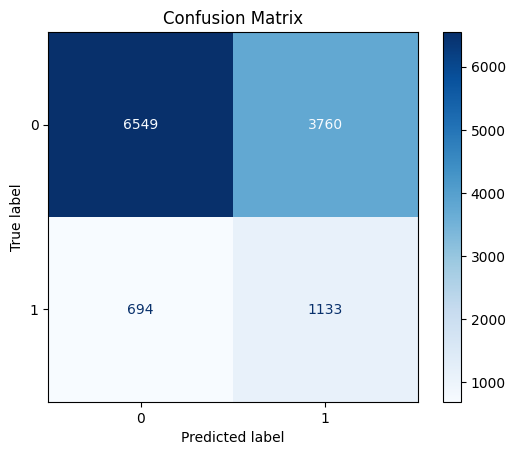


Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.64      0.75     10309
         1.0       0.23      0.62      0.34      1827

    accuracy                           0.63     12136
   macro avg       0.57      0.63      0.54     12136
weighted avg       0.80      0.63      0.68     12136

Balanced Accuracy: 0.628
MCC: 0.186


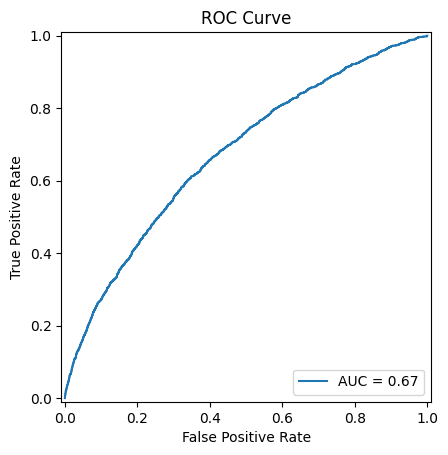

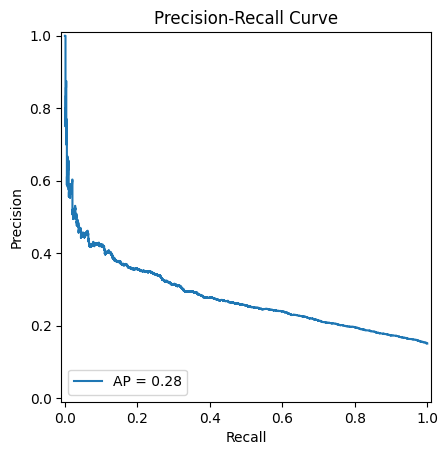

In [ ]:
y_pred = best_ridge.predict(X_test)
y_proba = best_ridge.predict_proba(X_test)[:, 1]
classification_metrics(y_test, y_pred, y_proba)

LASSO

In [ ]:
# lasso
lr_params = {
        "logit__penalty": ["l1"],
        "logit__C": loguniform(1, 2), # loguniform(1e-4, 1e2)-> 1.77
    }

rs_lasso = logit_rs_pipe(preprocessor_v1, lr_params)
rs_lasso.fit(X_train_small, y_train_small)

print(rs_lasso.best_params_)
print(rs_lasso.best_score_)

best_lasso = rs_lasso.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'logit__C': np.float64(1.9587181994334268), 'logit__penalty': 'l1'}
0.26750232124739437


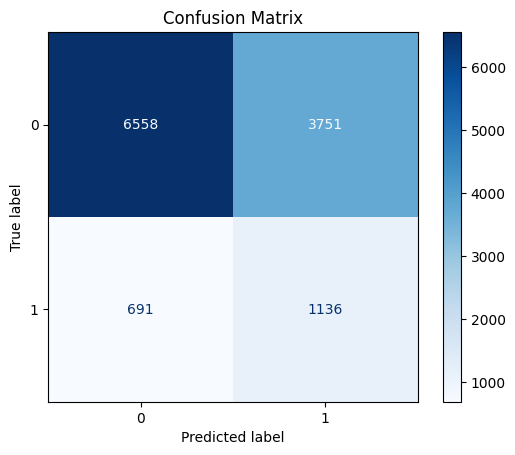


Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.64      0.75     10309
         1.0       0.23      0.62      0.34      1827

    accuracy                           0.63     12136
   macro avg       0.57      0.63      0.54     12136
weighted avg       0.80      0.63      0.69     12136

Balanced Accuracy: 0.629
MCC: 0.188


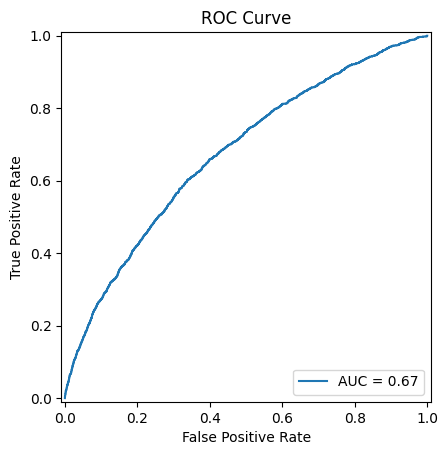

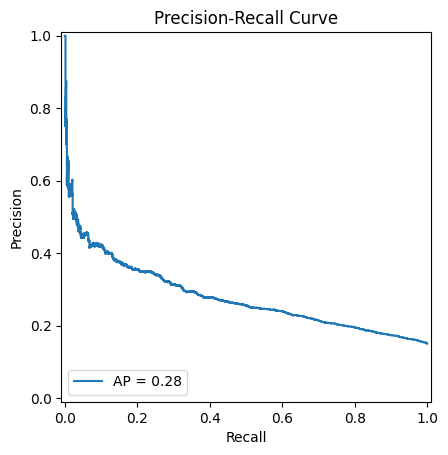

In [ ]:
y_pred = best_lasso.predict(X_test)
y_proba = best_lasso.predict_proba(X_test)[:, 1]
classification_metrics(y_test, y_pred, y_proba)

Elastic-net

In [ ]:
# Elastic-net
lr_params = {
        "logit__penalty": ["elasticnet"],
        "logit__l1_ratio": uniform(0.0, 1.0),
        "logit__C":  uniform(0.0, 1.0)} # 0.97

rs_elastic = logit_rs_pipe(preprocessor_v1, lr_params)
rs_elastic.fit(X_train_small, y_train_small)

print(rs_elastic.best_params_)
print(rs_elastic.best_score_)

best_elastic = rs_elastic.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'logit__C': np.float64(0.9656320330745594), 'logit__l1_ratio': np.float64(0.8083973481164611), 'logit__penalty': 'elasticnet'}
0.2673813559779972


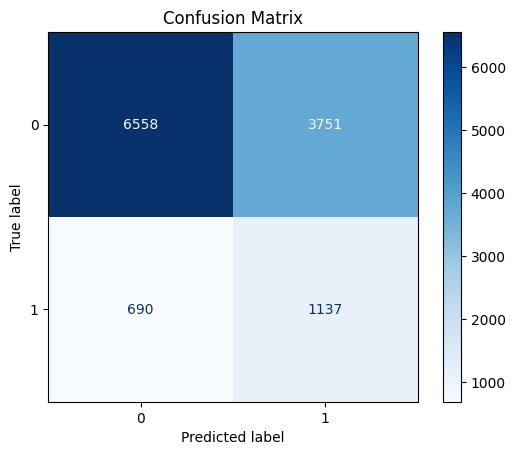


Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.64      0.75     10309
         1.0       0.23      0.62      0.34      1827

    accuracy                           0.63     12136
   macro avg       0.57      0.63      0.54     12136
weighted avg       0.80      0.63      0.69     12136

Balanced Accuracy: 0.629
MCC: 0.188


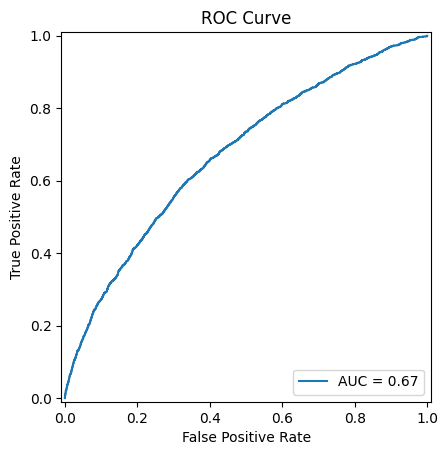

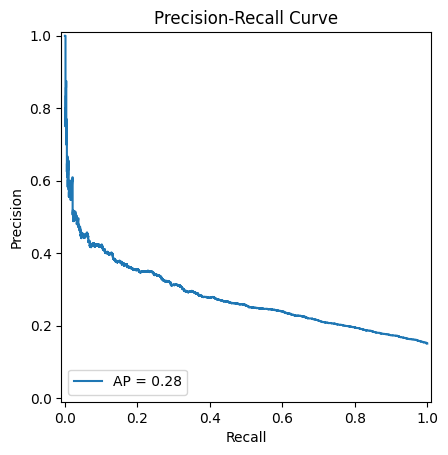

In [ ]:
y_pred = best_elastic.predict(X_test)
y_proba = best_elastic.predict_proba(X_test)[:, 1]
classification_metrics(y_test, y_pred, y_proba)

In [ ]:
# feature names after preprocessing
best_elastic = rs_elastic.best_estimator_

feat_names = (
    best_elastic.named_steps["prep"]
    .named_steps["ct"]
    .get_feature_names_out()
)

coefs = best_elastic.named_steps["logit"].coef_.ravel()

df = pd.DataFrame({
    "feature": feat_names,
    "coef": coefs
})
df["abs_coef"] = df["coef"].abs()

df = df.sort_values("abs_coef", ascending=False).reset_index(drop=True)

print(f"Number of non-zero coefficients: {df[df['abs_coef']>0].shape[0]}")
df.head(10)

Number of non-zero coefficients: 56


,feature,coef,abs_coef
0,log__AMT_CREDIT,-1.195743,1.195743
1,log__AMT_ANNUITY,0.920408,0.920408
2,num__PAYMENT_RATE,-0.611755,0.611755
3,ohe__NAME_INCOME_TYPE_Pensioner,0.385645,0.385645
4,num__FLAG_EMP_PHONE,0.239889,0.239889
5,num__CREDIT_TO_GOODS,0.202088,0.202088
6,ohe__CODE_GENDER_M,0.186399,0.186399
7,num__YEARS_EMPLOYED,-0.183592,0.183592
8,ohe__FLAG_OWN_CAR_Y,-0.179681,0.179681
9,te__ORGANIZATION_TYPE,0.179363,0.179363


In [ ]:
def compare_models(models, X_test, y_test, model_type=None):
    """
    Compare fitted RandomizedSearchCV models.

    Parameters
    ----------
    models : dict
        {"Ridge": rs_ridge, "Lasso": rs_lasso, ...}
    X_test, y_test : test data
    model_type : str or None
        If "logit", also compute number of non-zero coefficients.

    Returns
    -------
    DataFrame
    """
    rows = []

    for name, rs in models.items():
        best = rs.best_estimator_

        y_proba = best.predict_proba(X_test)[:, 1]

        row = {
            "model": name,
            "cv_pr_auc": rs.best_score_,
            "cv_roc_auc": rs.cv_results_["mean_test_roc_auc"][rs.best_index_],
            "test_pr_auc": average_precision_score(y_test, y_proba),
            "test_roc_auc": roc_auc_score(y_test, y_proba),
            "best_params": rs.best_params_
        }

        if model_type == "logit":
            coefs = best.named_steps["logit"].coef_.ravel()
            row["n_nonzero_coefs"] = int(np.sum(np.abs(coefs) > 1e-8))

        rows.append(row)

    return pd.DataFrame(rows).sort_values("cv_pr_auc", ascending=False)


In [ ]:
models= {
    "Ridge": rs_ridge,
    "Lasso": rs_lasso,
    "ElasticNet": rs_elastic
}

compare_models(models, X_test, y_test, model_type='logit')

,model,cv_pr_auc,cv_roc_auc,test_pr_auc,test_roc_auc,best_params,n_nonzero_coefs
1,Lasso,0.267502,0.664741,0.279927,0.673709,"{'logit__C': 1.9587181994334268, 'logit__penal...",56
2,ElasticNet,0.267381,0.664596,0.279837,0.673634,"{'logit__C': 0.9656320330745594, 'logit__l1_ra...",56
0,Ridge,0.267356,0.664859,0.280006,0.673757,"{'logit__C': 57.82149035051362, 'logit__penalt...",56


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


Overall, the results are very similar, with negligible differences across models and no feature selection. But the best is the CV is the Lasso regularization method.

Since linear models are sensitive to multicollinearity and can suffer from coefficient instability, I additionally test a pipeline using DropCorrelatedFeatures to remove features with pairwise correlations above 0.75. To assess whether explicitly removing correlated features, together with Ridge improves performance, particularly given that Lasso didn't result in feature selection.

In [ ]:
# Test using DropCorrelatedFeatures
from feature_engine.selection import DropCorrelatedFeatures

num_drop_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("drop_corr", DropCorrelatedFeatures(method="pearson", threshold=0.75))
])

preprocessor_v4 = Pipeline(steps=[
        ("car_age", OwnCarAgeImputer()), # Corrected typo
        ("income_clean", IncomeTypeCleaner("NAME_INCOME_TYPE")), # Corrected typo
        ("ct", ColumnTransformer(
            transformers=[
                ("ohe", ohe_pipe, ohe_vars),
                ("num", num_drop_pipe, num_vars),
                ("log", log_pipe, log_vars),
                ("edu", edu_pipe, edu_col),
                ("te", te_pipe, te_cols),
            ],
            verbose_feature_names_out=True))
    ])

lr_params = {
        "logit__penalty": ["l2"], #Ridge
        "logit__C": loguniform(40, 60),
    }

rs_lasso_test = logit_rs_pipe(preprocessor_v4, lr_params)
rs_lasso_test.fit(X_train_small, y_train_small)

print(rs_lasso_test.best_params_)
print(rs_lasso_test.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'logit__C': np.float64(53.821739036591396), 'logit__penalty': 'l2'}
0.2670169585197824


In [ ]:
# Check how many features dropped
best_lasso_test = rs_lasso_test.best_estimator_
ct = best_lasso_test.named_steps["prep"].named_steps["ct"]
num_pipe_fitted = ct.named_transformers_["num"]
dropper = num_pipe_fitted.named_steps["drop_corr"]

In [ ]:
dropped = dropper.features_to_drop_
print("Dropped numeric features:", len(dropped))

Dropped numeric features: 3


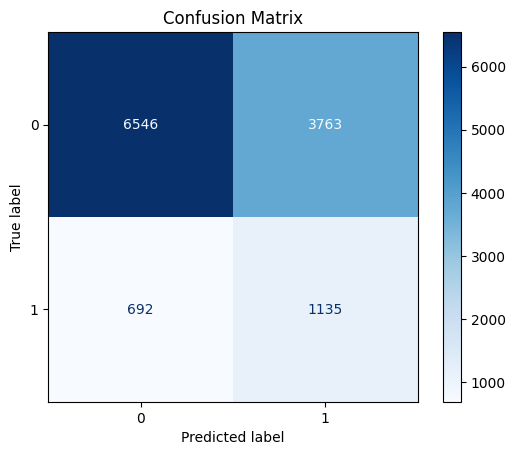


Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.63      0.75     10309
         1.0       0.23      0.62      0.34      1827

    accuracy                           0.63     12136
   macro avg       0.57      0.63      0.54     12136
weighted avg       0.80      0.63      0.68     12136

Balanced Accuracy: 0.628
MCC: 0.187


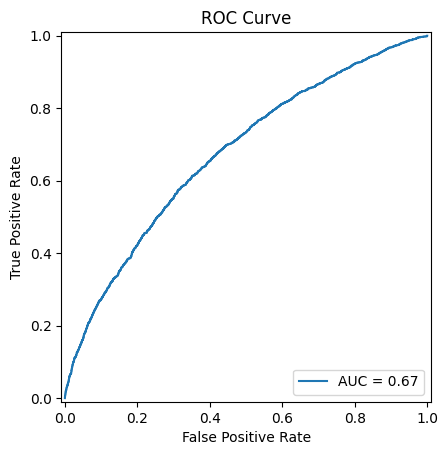

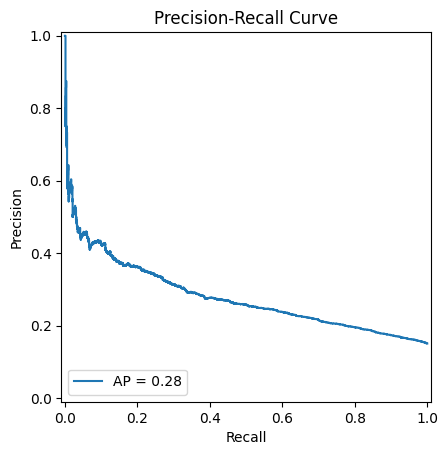

In [ ]:
best_lasso_test = rs_lasso_test.best_estimator_
y_pred = best_lasso_test.predict(X_test)
y_proba = best_lasso_test.predict_proba(X_test)[:, 1]
classification_metrics(y_test, y_pred, y_proba)

Using DropCorrelated Features PR-AUC: 0.267017
Using Ridge PR-AUC: 0.0.267355

Removing correlated features does not improve performance relative to Ridge-based regularization.

##### PCA with logistic regression

To address multicollinearity and dimensionality, I test PCA before logistic regression.

### Pros:
- Reduces dimensionality
- Removes multicollinearity

### Cons:
- Unsupervised (does not optimize prediction)
- Not interpretable

**Result:**  
PCA did not improve PR-AUC and selected nearly all components.  
It does not meaningfully reduce dimensionality in this dataset.


In [ ]:
pca = PCA(n_components=None, random_state=42)

pca_pipe = Pipeline([
    ("prep", preprocessor_v1),
    ("scale", StandardScaler(with_mean=False)),
    ("pca", pca)
])

pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 Pipeline(steps=[('car_age', OwnCarAgeImputer()),
                                 ('income_clean', IncomeTypeCleaner()),
                                 ('ct',
                                  ColumnTransformer(transformers=[('ohe',
                                                                   Pipeline(steps=[('imp',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ohe',
                                                                                    OneHotEncoder(drop='first',
                                                                                                  handle_unknown='infrequent_if_exist',
                                                                                                  min_frequency=20))]),
                                                                   ['NAME_CONTRACT_TYPE',
                                                                    'CODE_GENDER',
                                                                    'FLAG...
                                                                                                                'Academic '
                                                                                                                'degree']],
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['NAME_EDUCATION_TYPE']),
                                                                  ('te',
                                                                   Pipeline(steps=[('te',
                                                                                    TargetEncoder(cols=['OCCUPATION_TYPE',
                                                                                                        'ORGANIZATION_TYPE',
                                                                                                        'NAME_HOUSING_TYPE']))]),
                                                                   ['OCCUPATION_TYPE',
                                                                    'ORGANIZATION_TYPE',
                                                                    'NAME_HOUSING_TYPE'])]))])),
                ('scale', StandardScaler(with_mean=False)),
                ('pca', PCA(random_state=42))])

In [ ]:
components = pca_pipe.named_steps["pca"].components_
cols  = pca_pipe.named_steps["prep"].named_steps["ct"].get_feature_names_out()


components = pd.DataFrame(components,
                          columns=cols).T

ncomp = pca_pipe.named_steps["pca"].n_components_
components.columns = [f"pc{i}" for i in range(1, ncomp+1)]

In [ ]:
components.shape

(56, 56)

In [ ]:
components.pc1.abs().nlargest(5)

,pc1
num__LIVINGAREA_AVG,0.374796
num__APARTMENTS_AVG,0.372703
num__ELEVATORS_AVG,0.357735
num__LIVINGAPARTMENTS_AVG,0.331848
num__FLOORSMAX_AVG,0.300384


These are the top 5 feature most contributing to the first principal component (PC1).

 Applicants with:
 * larger living areas
 * large apartments
 * more elevators
 * taller buildings

will score high on PC1.

In [ ]:
components.pc2.abs().nlargest(5)

,pc2
num__FLAG_EMP_PHONE,0.432585
ohe__NAME_INCOME_TYPE_Pensioner,0.432517
num__AGE,0.360888
te__ORGANIZATION_TYPE,0.331212
ohe__NAME_INCOME_TYPE_Working,0.271426


In [ ]:
components.pc3.abs().nlargest(5)

,pc3
log__AMT_CREDIT,0.495823
log__AMT_ANNUITY,0.444126
num__CREDIT_TO_INCOME,0.432181
num__ANNUITY_TO_INCOME,0.359212
num__PAYMENT_RATE,0.265095


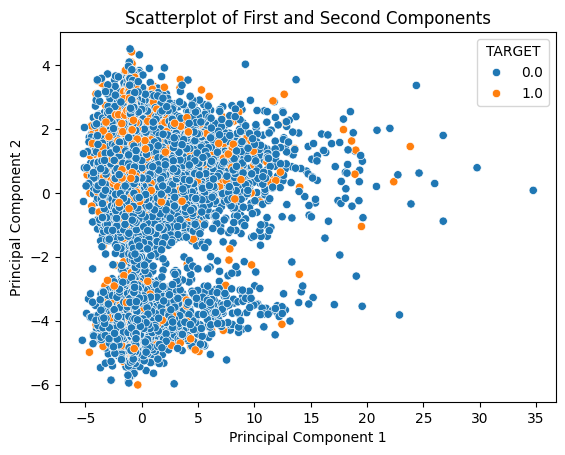

In [ ]:
# plot the principal components
X_train_pca = pd.DataFrame(pca_pipe.transform(X_train_small),
  columns=components.columns, index=X_train_small.index)
X_train_pca["TARGET"] = np.ravel(y_train_small)

sns.scatterplot(x=X_train_pca.pc1, y=X_train_pca.pc2, hue=X_train_pca.TARGET)
plt.title("Scatterplot of First and Second Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

This means 2 components don't explain all the variance.

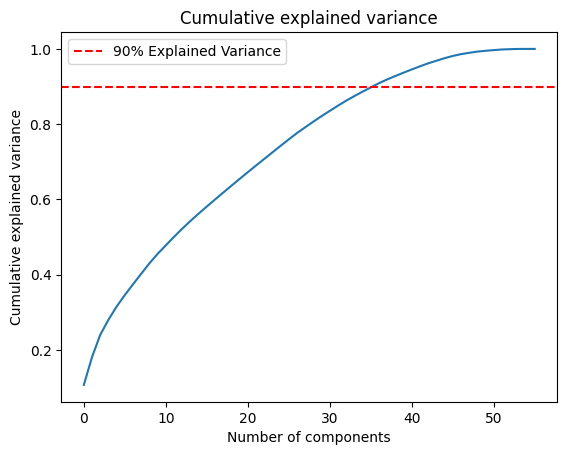

In [ ]:
pca= pca_pipe.named_steps['pca']
cum_var = pca.explained_variance_ratio_.cumsum()
plt.plot(cum_var)
plt.axhline(0.90, color='r', linestyle='--', label='90% Explained Variance')
plt.title('Cumulative explained variance')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.legend()
plt.show()

It seems like 45 components capture almost all the variance.

In [ ]:
lr = LogisticRegression(random_state=42, max_iter=5000,
                        class_weight= 'balanced', penalty = 'l2', solver='saga') # use Ridge

pca = PCA(random_state=42)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lr_pca_pipe = Pipeline([
    ("prep", preprocessor_v1),
    ("scale", StandardScaler(with_mean=False)),
    ("pca", pca),
    ("lr", lr)
])

'''C_grid = [
    0.1, 0.2, 0.4, 0.6, 0.8, 1.0,
    2.0, 2.5, 4.0, 10.0, 40.0, 60.0
]'''

lr_pca_params = {
  "pca__n_components": list(range(30,56)), # picked 54
  "lr__C": loguniform(1e-4, 0.5) # piked 0.1
  #uniform(loc=0, scale=4)
  #
}
scoring_metrics= {"roc_auc": "roc_auc", "pr_auc": "average_precision"}

rs_pca = RandomizedSearchCV(
        estimator=lr_pca_pipe,
        param_distributions=lr_pca_params,
        cv=cv,
        n_iter=20,
        scoring= scoring_metrics,
        refit="pr_auc",
        random_state=42,
        n_jobs=-1,
        verbose = 1)

rs_pca.fit(X_train_small, y_train_small)

print(rs_pca.best_params_)
print(rs_pca.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'lr__C': np.float64(0.019232935818803913), 'pca__n_components': 55}
0.26394681188724256


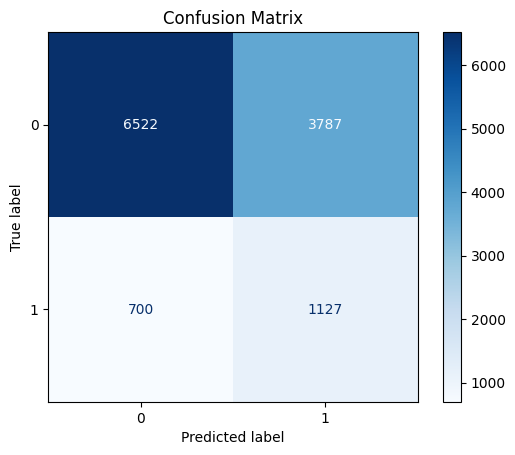


Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.63      0.74     10309
         1.0       0.23      0.62      0.33      1827

    accuracy                           0.63     12136
   macro avg       0.57      0.62      0.54     12136
weighted avg       0.80      0.63      0.68     12136

Balanced Accuracy: 0.625
MCC: 0.182


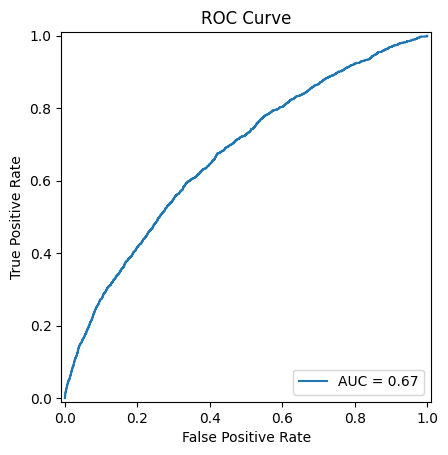

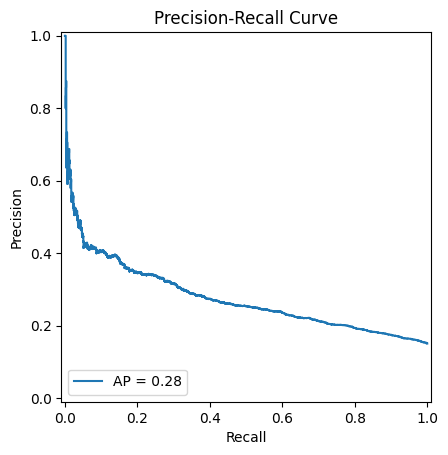

In [ ]:
best_lr = rs_pca.best_estimator_
y_pred = best_lr.predict(X_test)
y_proba = best_lr.predict_proba(X_test)[:, 1]
classification_metrics(y_test, y_pred, y_proba)

The PCA performed worst than the logistic regression, and does little dimensionality reduction, as it picks 55/56 PC.  


#### Linear SVC

Linear SVC learns a margin-based linear boundary.

Advantages:
- Works well in high-dimensional spaces
- Can improve minority recall

Important:

> Linear SVC produces decision scores, not calibrated probabilities.

PR-AUC and ROC-AUC are computed using decision scores.

**Result:**  
Performance is similar to logistic regression.

In [ ]:
svc_pipe = Pipeline([
    ("prep", preprocessor_v1),
    ("scale", StandardScaler(with_mean=False)),
    ("svc", LinearSVC(class_weight="balanced", random_state=42))
])

params = {"svc__C": uniform(loc=0, scale=100)}

rs_linearSVC = RandomizedSearchCV(svc_pipe, params, cv=cv, n_iter=20,
                                  scoring= scoring_metrics,
                                  refit= 'pr_auc', n_jobs=-1,
                                  random_state=42, verbose=1)

rs_linearSVC.fit(X_train_small, y_train_small)
print(rs_linearSVC.best_params_)
print(rs_linearSVC.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'svc__C': np.float64(2.0584494295802447)}
0.2677889936425897


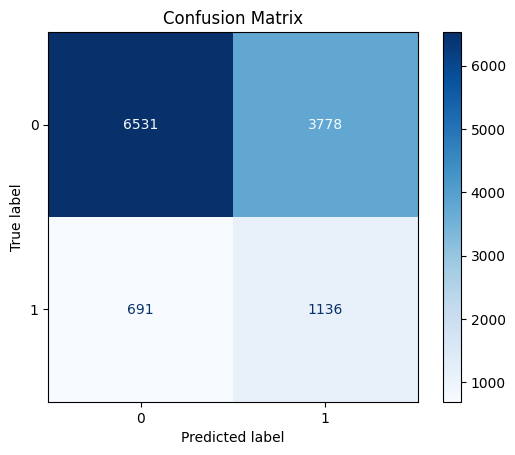


Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.63      0.75     10309
         1.0       0.23      0.62      0.34      1827

    accuracy                           0.63     12136
   macro avg       0.57      0.63      0.54     12136
weighted avg       0.80      0.63      0.68     12136

Balanced Accuracy: 0.628
MCC: 0.186


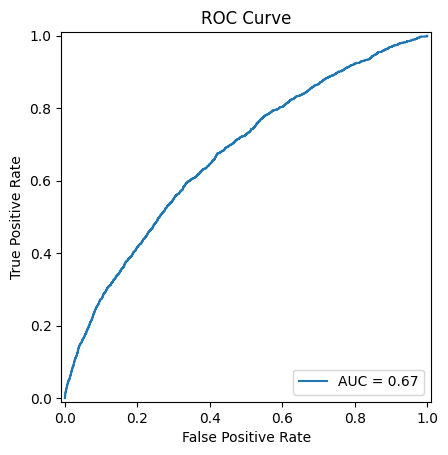

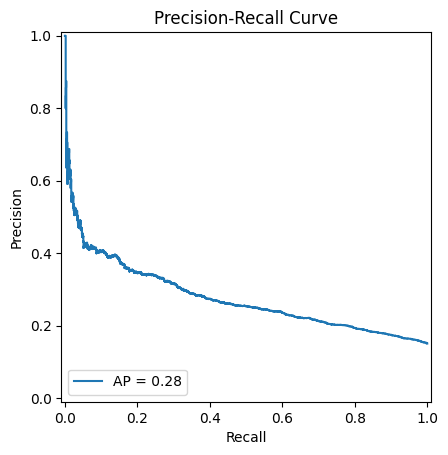

In [ ]:
best_linearSVC = rs_linearSVC.best_estimator_
y_pred = best_linearSVC.predict(X_test)
classification_metrics(y_test, y_pred, y_proba)

Results for Linear SVC are marginaly better than Logit Regression.

* linear SVC - PR-AUC: 0.2677889936425897

* ridge - PR-AUC: 0.26735590403415493



#### KNN

KNN is a distance-based classifier.

Challenges:
- Suffers in high dimensions
- Sensitive to imbalance
- Sensitive to scaling and outliers

Despite careful preprocessing, KNN underperforms linear models — as expected.


In [ ]:
knn_pipe1 = Pipeline([
    ("prep", preprocessor_v3), #
    ("scale", StandardScaler(with_mean=False)),
    ("knn", KNeighborsClassifier())
])

knn_params = {
    "knn__n_neighbors": randint(80, 100), # 79
    "knn__Iights": ["uniform", "distance"],
    "knn__p": [1, 2],  # manhattan vs euclidean
}

rs_knn1 = RandomizedSearchCV(
    knn_pipe1, knn_params,
    cv=cv, n_iter=20,
    scoring= scoring_metrics,
    refit='pr_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rs_knn1.fit(X_train_small, y_train_small)

print(rs_knn1.best_params_)
print(rs_knn1.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'knn__n_neighbors': 95, 'knn__p': 1, 'knn__weights': 'distance'}
0.23875503948565557


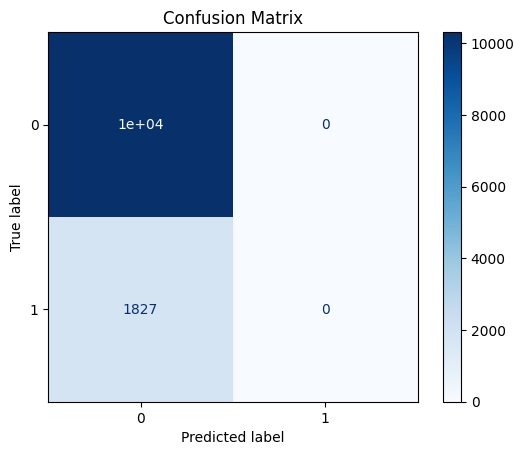


Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92     10309
         1.0       0.00      0.00      0.00      1827

    accuracy                           0.85     12136
   macro avg       0.42      0.50      0.46     12136
weighted avg       0.72      0.85      0.78     12136

Balanced Accuracy: 0.500
MCC: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


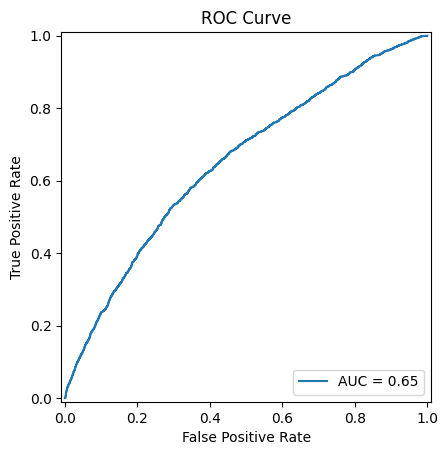

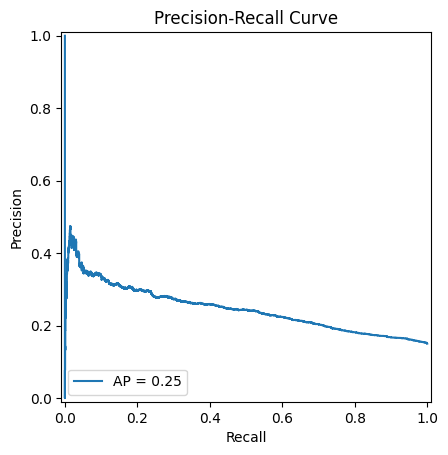

In [ ]:
best_knn = rs_knn1.best_estimator_
y_pred = best_knn.predict(X_test)
y_proba = best_knn.predict_proba(X_test)[:, 1]
classification_metrics(y_test, y_pred, y_proba)

In [ ]:
# Test with another preprocessor, that doesn't treat outliers
knn_pipe2 = Pipeline([
    ("prep", preprocessor_v1), #
    ("scale", StandardScaler(with_mean=False)),
    ("knn", KNeighborsClassifier())
])

rs_knn2 = RandomizedSearchCV(
    knn_pipe2, knn_params,
    cv=3, n_iter=20,
    scoring= scoring_metrics,
    refit='pr_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rs_knn2.fit(X_train_small, y_train_small)

print(rs_knn2.best_params_)
print(rs_knn2.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'knn__n_neighbors': 95, 'knn__p': 1, 'knn__weights': 'distance'}
0.2390346919322266


KNN exhibits worse performance compared to logistic regression.
This is expected, as KNN is a distance-based method that performs poorly in high-dimensional, imbalanced datasets. KNN makes purely local decisions and does not learn a global decision boundary, unlike logistic regression.

#### Decision Tree

- Fully interpretable
- Captures nonlinear relationships
- High variance

**Result**:
underperforms logistic regression.


In [ ]:
# Standard Preprocessor Method for Non linear
preprocessor_non_linear = Pipeline(steps=[
    ("car_age", OwnCarAgeImputer()), # apply your rule inside pipeline
    ("income_clean", IncomeTypeCleaner("NAME_INCOME_TYPE")),
    ("ct", ColumnTransformer(
        transformers=[
            ("ohe", ohe_pipe, ohe_vars),
            ("num", num_pipe, list(num_vars) + list(log_vars)),
            ("edu", edu_pipe, edu_col),
            ("te", te_pipe, te_cols),
        ],
        verbose_feature_names_out=True
    ))
])

In [ ]:
# Example Decision Tree
dtc_pipe1 = Pipeline([
    ("prep", preprocessor_non_linear),
    ("dtc", DecisionTreeClassifier(
        random_state=42,
        class_weight="balanced"
    ))
])

dtc_pipe1.fit(X_train_small, y_train_small)


Pipeline(steps=[('prep',
                 Pipeline(steps=[('car_age', OwnCarAgeImputer()),
                                 ('income_clean', IncomeTypeCleaner()),
                                 ('ct',
                                  ColumnTransformer(transformers=[('ohe',
                                                                   Pipeline(steps=[('imp',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ohe',
                                                                                    OneHotEncoder(drop='first',
                                                                                                  handle_unknown='infrequent_if_exist',
                                                                                                  min_frequency=20))]),
                                                                   ['NAME_CONTRACT_TYPE',
                                                                    'CODE_GENDER',
                                                                    'FLAG...
                                                                                                                'Academic '
                                                                                                                'degree']],
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['NAME_EDUCATION_TYPE']),
                                                                  ('te',
                                                                   Pipeline(steps=[('te',
                                                                                    TargetEncoder(cols=['OCCUPATION_TYPE',
                                                                                                        'ORGANIZATION_TYPE',
                                                                                                        'NAME_HOUSING_TYPE']))]),
                                                                   ['OCCUPATION_TYPE',
                                                                    'ORGANIZATION_TYPE',
                                                                    'NAME_HOUSING_TYPE'])]))])),
                ('dtc',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

In [ ]:
ct = dtc_pipe1.named_steps["prep"].named_steps["ct"]
new_cols = ct.get_feature_names_out()

feature_imp = dtc_pipe1.named_steps["dtc"].feature_importances_
imp_df = (pd.DataFrame({"feature": new_cols, "importance": feature_imp})
          .sort_values("importance", ascending=False))
imp_df.head(30)

,feature,importance
39,num__AGE,0.083696
40,num__YEARS_EMPLOYED,0.080590
46,num__PAYMENT_RATE,0.074824
20,num__REGION_POPULATION_RELATIVE,0.055874
51,num__AMT_ANNUITY,0.051608
45,num__ANNUITY_TO_INCOME,0.051408
44,num__CREDIT_TO_INCOME,0.046819
43,num__CREDIT_TO_GOODS,0.045383
50,num__AMT_CREDIT,0.045304
54,te__ORGANIZATION_TYPE,0.039339


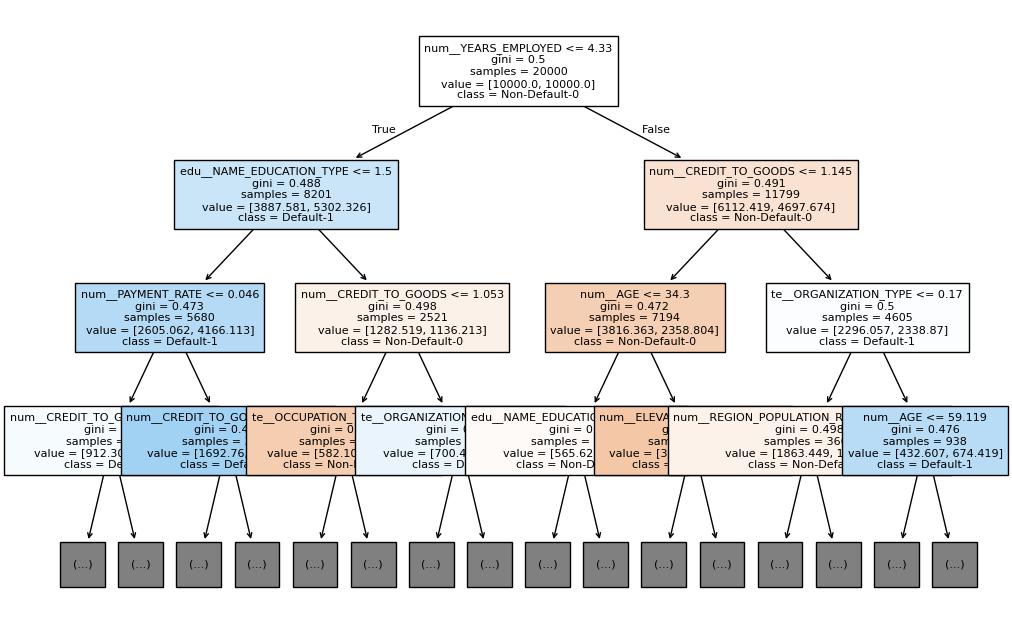

In [ ]:
plt.figure(figsize=(12, 8))
plot_tree(
    dtc_pipe1.named_steps["dtc"],
    feature_names=new_cols,
    class_names=['Non-Default-0', "Default-1"],
    filled=True,
    max_depth=3,
    fontsize=8
)

plt.show()

The root split is based on YEARS_EMPLOYED, indicating that employment tenure is the most informative variable in the tree. Applicants with shorter employment histories are systematically associated with higher default risk.

Conditional on employment stability, applicants with higher CREDIT_TO_GOODS ratios exhibit elevated default risk, suggesting that affordability constraints further amplify vulnerability.

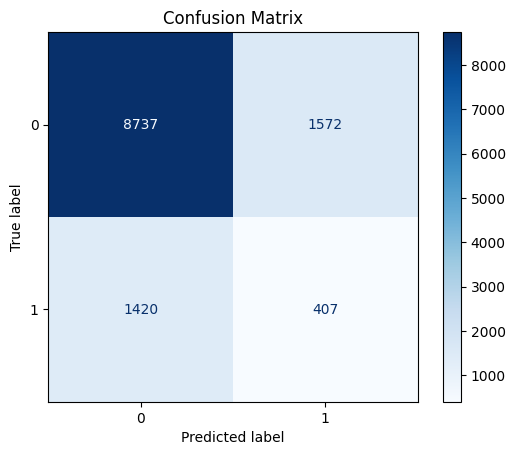


Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.85      0.85     10309
         1.0       0.21      0.22      0.21      1827

    accuracy                           0.75     12136
   macro avg       0.53      0.54      0.53     12136
weighted avg       0.76      0.75      0.76     12136

Balanced Accuracy: 0.535
MCC: 0.068


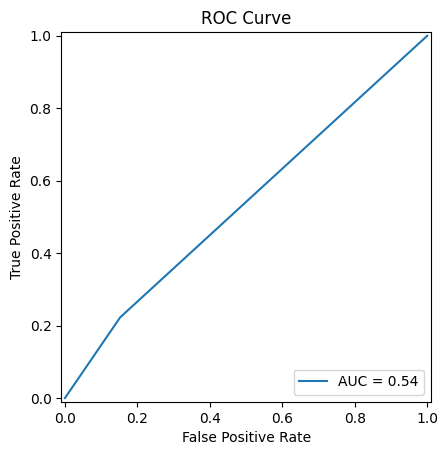

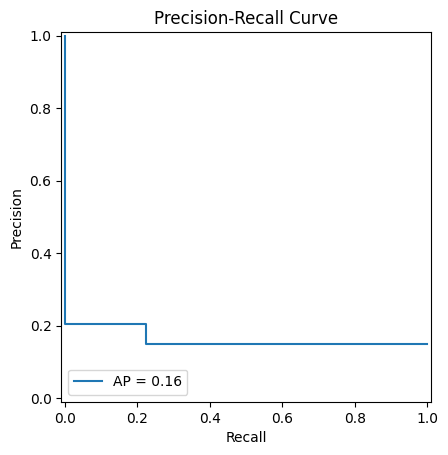

In [ ]:
y_pred = dtc_pipe1.predict(X_test)
y_proba = dtc_pipe1.predict_proba(X_test)[:, 1]
classification_metrics(y_test, y_pred, y_proba)

In [ ]:
# Parameter tuning

dtc_pipe2 = Pipeline([
    ("prep", preprocessor_non_linear),
    ("dtc", DecisionTreeClassifier(
        random_state=42,
        class_weight="balanced"
    ))
])

dtc_params = {
 'dtc__min_samples_leaf': randint(100, 1200),
 'dtc__max_depth': randint(2, 11)
}

rs_tree = RandomizedSearchCV(dtc_pipe2,
                             dtc_params,
                             cv=cv,
                             n_iter=20,
                             scoring= scoring_metrics,
                             refit='pr_auc',
                             n_jobs=-1,
                             verbose=1
                             )

rs_tree.fit(X_train_small, y_train_small)

print(rs_tree.best_params_)
print(rs_tree.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'dtc__max_depth': 9, 'dtc__min_samples_leaf': 228}
0.2276098155573064


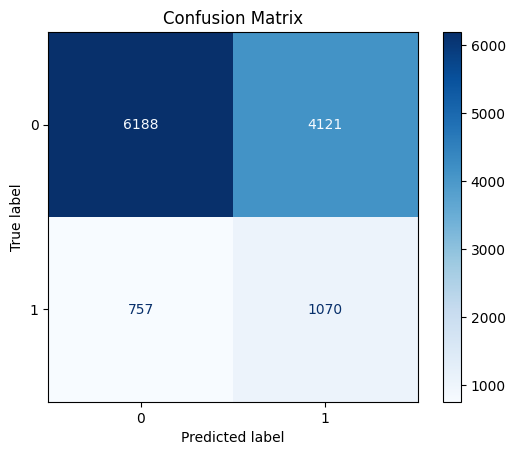


Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.60      0.72     10309
         1.0       0.21      0.59      0.30      1827

    accuracy                           0.60     12136
   macro avg       0.55      0.59      0.51     12136
weighted avg       0.79      0.60      0.66     12136

Balanced Accuracy: 0.593
MCC: 0.134


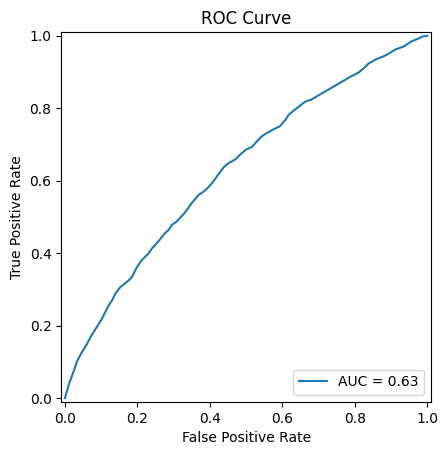

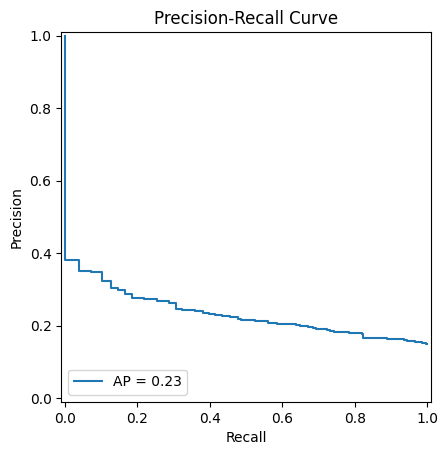

In [ ]:
best_tree = rs_tree.best_estimator_
y_pred = best_tree.predict(X_test)
y_proba = best_tree.predict_proba(X_test)[:, 1]
classification_metrics(y_test, y_pred, y_proba)

The decision tree exhibits even worse performance, achieving the loIst PR–AUC among the models evaluated. It performs poorly at correctly identifying loan defaults across different score thresholds. Also, it has a loIr MCC values indicate that its predictions are more random than for other models.

Overall, the Decision Tree underperforms Logistic Regression in terms of PR-AUC and ROC-AUC.

#### Random Forest

A random forest is an ensemble learning method that combines multiple decision trees to improve accuracy and robustness. Each tree is trained on a random subset of the data and features, and their predictions are aggregated (majority voting for classification or averaging for regression). This reduces overfitting and increases generalization.

As a tree-based model, random forests are also not sensitive to outliers. Therefore, I apply the same preprocessing strategy as for the decision tree.

**Result:** Improves over single tree but still underperforms gradient boosting.

In [ ]:
rfc = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",
    n_jobs=-1, #paralelalize
    max_features="sqrt",
    bootstrap=True
)

rfc_pipe = Pipeline([
    ("prep", preprocessor_non_linear),
    ("rfc", rfc)
])

rfc_params = {
    "rfc__n_estimators": randint(200,260), # 250
    "rfc__max_depth": [None, 2, 4, 8],
    "rfc__min_samples_leaf": randint(20,40), #30
    "rfc__min_samples_split": randint(110,140) #125
}

rs_rf = RandomizedSearchCV(rfc_pipe, rfc_params, cv=cv,
  n_iter=20, scoring= scoring_metrics, refit='pr_auc', n_jobs=-1, verbose=1)

rs_rf.fit(X_train_small, y_train_small)

print(rs_rf.best_params_)
print(rs_rf.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'rfc__max_depth': None, 'rfc__min_samples_leaf': 34, 'rfc__min_samples_split': 125, 'rfc__n_estimators': 239}
0.2668272600359179


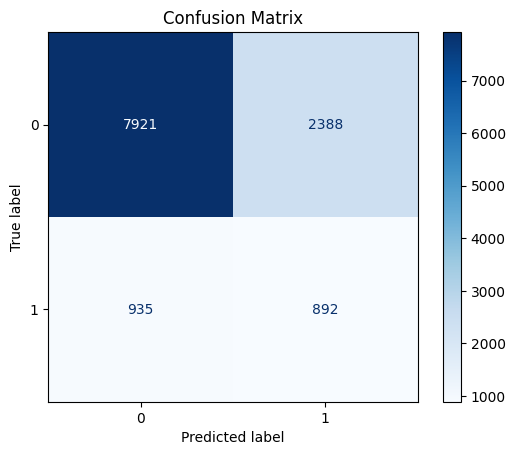


Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.77      0.83     10309
         1.0       0.27      0.49      0.35      1827

    accuracy                           0.73     12136
   macro avg       0.58      0.63      0.59     12136
weighted avg       0.80      0.73      0.75     12136

Balanced Accuracy: 0.628
MCC: 0.207


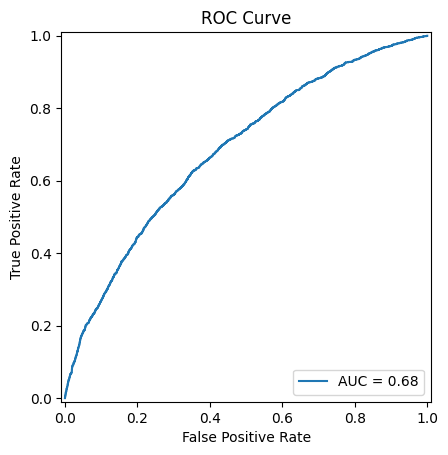

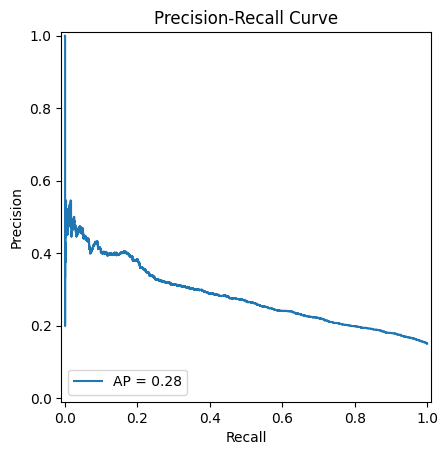

In [ ]:
best_rfc = rs_rf.best_estimator_
y_pred = best_rfc.predict(X_test)
y_proba = best_rfc.predict_proba(X_test)[:, 1]
classification_metrics(y_test, y_pred, y_proba)

#### LightGBM

LightGBM is a gradient boosting model optimized for structured/tabular data.

Advantages:
- Captures nonlinearities and interactions
- Handles high-dimensional features efficiently
- Strong ranking performance under imbalance

For LightGBM:
- No scaling
- No explicit outlier handling
- One-hot encoding only

**Result:**  
LightGBM achieves the highest PR-AUC and ROC-AUC across models.

Repeated tuning with different seeds produced nearly identical results, indicating stability.

In [ ]:
# the simples to run quicker
preprocessor_lgbm = Pipeline(steps=[
    ("car_age", OwnCarAgeImputer()),
    ("income_clean", IncomeTypeCleaner("NAME_INCOME_TYPE")),
    ("ct", ColumnTransformer(
        transformers=[
            ("ohe", ohe_pipe, list(ohe_vars) + list(te_cols)),
            ("num", num_pipe, list(num_vars) + list(log_vars)),
            ("edu", edu_pipe, edu_col),
        ],
        verbose_feature_names_out=True
    ))
])


In [ ]:
# example
lgbm1 = LGBMClassifier(
    objective="binary",
    n_estimators=4000,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

lgbm_pipe1 = Pipeline([
    ("prep", preprocessor_lgbm),
    ("model", lgbm1)
])

# fit the pipeline
lgbm_pipe1.fit(X_train_small, y_train_small)

[LightGBM] [Info] Number of positive: 3010, number of negative: 16990
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4921
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 121
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


Pipeline(steps=[('prep',
                 Pipeline(steps=[('car_age', OwnCarAgeImputer()),
                                 ('income_clean', IncomeTypeCleaner()),
                                 ('ct',
                                  ColumnTransformer(transformers=[('ohe',
                                                                   Pipeline(steps=[('imp',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ohe',
                                                                                    OneHotEncoder(drop='first',
                                                                                                  handle_unknown='infrequent_if_exist',
                                                                                                  min_frequency=20))]),
                                                                   ['NAME_CONTRACT_TYPE',
                                                                    'CODE_GENDER',
                                                                    'FLAG...
                                                                                   ('ord',
                                                                                    OrdinalEncoder(categories=[['Lower '
                                                                                                                'secondary',
                                                                                                                'Secondary '
                                                                                                                '/ '
                                                                                                                'secondary '
                                                                                                                'special',
                                                                                                                'Incomplete '
                                                                                                                'higher',
                                                                                                                'Higher '
                                                                                                                'education',
                                                                                                                'Academic '
                                                                                                                'degree']],
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['NAME_EDUCATION_TYPE'])]))])),
                ('model',
                 LGBMClassifier(class_weight='balanced', n_estimators=4000,
                                n_jobs=-1, objective='binary',
                                random_state=42))])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


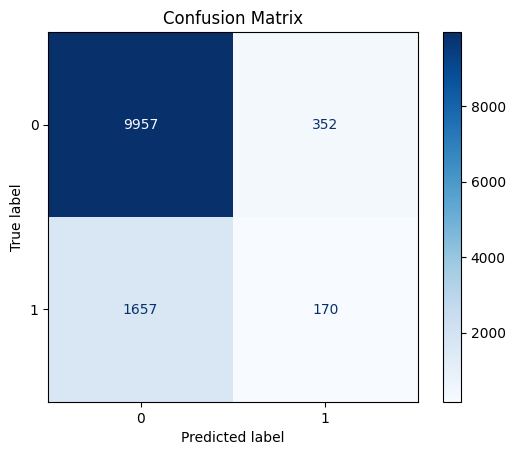


Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     10309
         1.0       0.33      0.09      0.14      1827

    accuracy                           0.83     12136
   macro avg       0.59      0.53      0.53     12136
weighted avg       0.78      0.83      0.79     12136

Balanced Accuracy: 0.529
MCC: 0.104


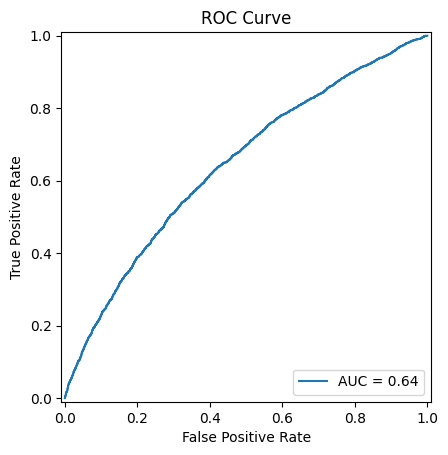

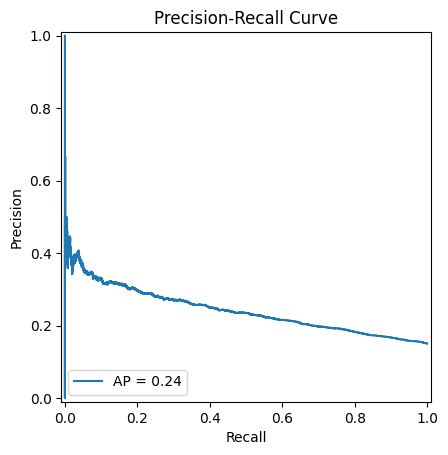

In [ ]:
y_pred  = lgbm_pipe1.predict(X_test)
y_proba = lgbm_pipe1.predict_proba(X_test)[:, 1]

classification_metrics(y_test, y_pred, y_proba)

In [ ]:
# Hyperparameter tuning
lgbm2 = LGBMClassifier(
    objective="binary",
    n_estimators=200,
    random_state=42,
    n_jobs=1,
    class_weight="balanced"
)

lgbm_pipe2 = Pipeline([
    ("prep", preprocessor_lgbm),
    ("lgbm", lgbm2)
])


param_dist = {
    "lgbm__learning_rate": loguniform(0.02, 0.1), #0.05
    "lgbm__num_leaves": randint(20, 50), # 31
    "lgbm__min_child_samples": randint(50, 150), #100
    "lgbm__subsample": [0.8, 1.0],
    "lgbm__colsample_bytree": [0.8, 1.0],
}

rs_lgbm1 = RandomizedSearchCV(
    lgbm_pipe2,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring=scoring_metrics,
    refit="pr_auc",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rs_lgbm1.fit(X_train_small, y_train_small)

print(rs_lgbm1.best_params_)
print(rs_lgbm1.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 3010, number of negative: 16990
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4871
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
{'lgbm__colsample_bytree': 0.8, 'lgbm__learning_rate': np.float64(0.02155248943349772), 'lgbm__min_child_samples': 100, 'lgbm__num_leaves': 26, 'lgbm__subsample': 0.8}
0.2743053836646761


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


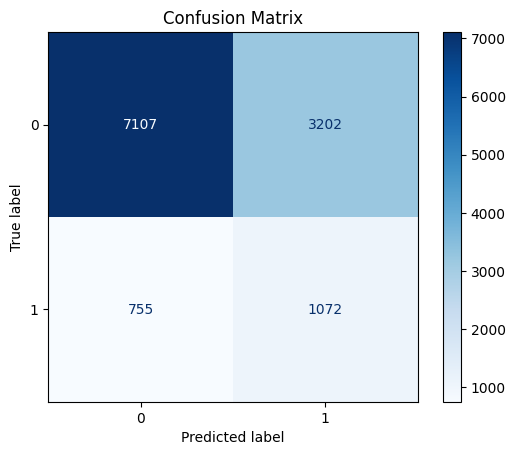


Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.69      0.78     10309
         1.0       0.25      0.59      0.35      1827

    accuracy                           0.67     12136
   macro avg       0.58      0.64      0.57     12136
weighted avg       0.81      0.67      0.72     12136

Balanced Accuracy: 0.638
MCC: 0.207


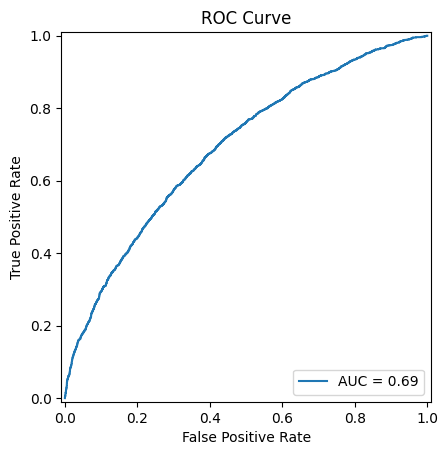

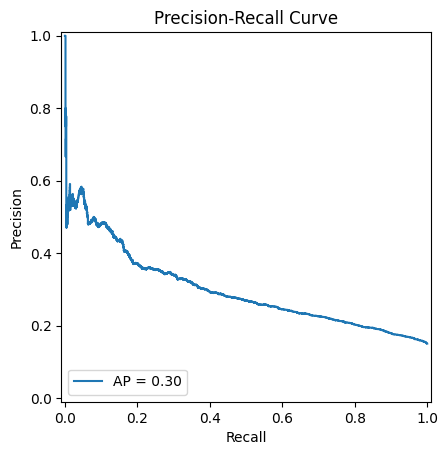

In [ ]:
best_lgbm1 = rs_lgbm1.best_estimator_
y_pred = best_lgbm1.predict(X_test)
y_proba = best_lgbm1.predict_proba(X_test)[:, 1]
classification_metrics(y_test, y_pred, y_proba)

Improved performance is observed across all evaluation metrics, with higher PR–AUC, ROC–AUC, and MCC. This improvement is driven by the model’s ability to capture nonlinear relationships and feature interactions that linear and simpler tree-based models cannot, leading to better separation betIen defaulting and non-defaulting loans.

##### Check if LIghtGBM is stable across states

I check the stability of LightGBM across random states. The model is evaluated using an alternative random seed to ensure that its performance and selected hyperparameters are not driven by randomness in data splitting or model initialization.

In [ ]:
# Hyperparameter tuning
lgbm3 = LGBMClassifier(
    objective="binary",
    n_estimators=200,
    random_state=1,
    n_jobs=1,
    class_weight="balanced"
)

lgbm_pipe3 = Pipeline([
    ("prep", preprocessor_lgbm),
    ("lgbm", lgbm3)
])


param_dist = {
    "lgbm__learning_rate": loguniform(0.02, 0.1), #0.05
    "lgbm__num_leaves": randint(20, 50), # 31
    "lgbm__min_child_samples": randint(50, 150), #100
    "lgbm__subsample": [0.8, 1.0],
    "lgbm__colsample_bytree": [0.8, 1.0],
}

rs_lgbm2 = RandomizedSearchCV(
    lgbm_pipe3,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring=scoring_metrics,
    refit="pr_auc",
    n_jobs=-1,
    random_state=1,
    verbose=1
)

rs_lgbm2.fit(X_train_small, y_train_small)

print(rs_lgbm2.best_params_)
print(rs_lgbm2.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 3010, number of negative: 16990
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4871
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
{'lgbm__colsample_bytree': 0.8, 'lgbm__learning_rate': np.float64(0.02129747502690752), 'lgbm__min_child_samples': 97, 'lgbm__num_leaves': 30, 'lgbm__subsample': 1.0}
0.2761040361186006


Repeating hyperparameter tuning with different random seeds (1 and 42) resulted in identical optimal hyperparameters and very similar cross-validated and test performance. This suggests that the model is stable and that results are not driven by randomness in data splitting or model initialization.

#### HistGradientBoostingClassifier

HistGradientBoostingClassifier is a gradient boosting model based on decision trees that uses histogram-based binning to improve computational efficiency. Like other tree-based methods, it captures nonlinear relationships and feature interactions while remaining robust to outliers. Its efficient training makes it particularly suitable for large datasets and high-dimensional feature spaces.

**Result:**
Performs similarly to LightGBM, confirming that gradient boosting is the appropriate model family.


In [ ]:
# Added since the model doesn't have a native class_weight parameter
sw_s = compute_sample_weight(class_weight="balanced", y=y_train_small)

hgb = HistGradientBoostingClassifier(
    random_state=42,
    learning_rate=0.05,
    max_iter=400
)

hgb_pipe = Pipeline([
    ("prep", preprocessor_non_linear),
    ("hgb", hgb)
])

hgb_params = {
    "hgb__max_depth": randint(5, 10), # around 7
    "hgb__max_leaf_nodes": randint(28, 40), # around 31
    "hgb__min_samples_leaf": randint(130, 160), # around 140
    "hgb__l2_regularization": [0.0, 0.1, 0.3, 1.0] # around 0.1
}

rs_hgb = RandomizedSearchCV(
    hgb_pipe,
    hgb_params,
    cv=cv, n_iter=20,
    scoring= scoring_metrics,
    refit='pr_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rs_hgb.fit(X_train_small, y_train_small, hgb__sample_Iight=sw_s)

print(rs_hgb.best_params_)
print(rs_hgb.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'hgb__l2_regularization': 0.0, 'hgb__max_depth': 9, 'hgb__max_leaf_nodes': 34, 'hgb__min_samples_leaf': 155}
0.27340143571436637


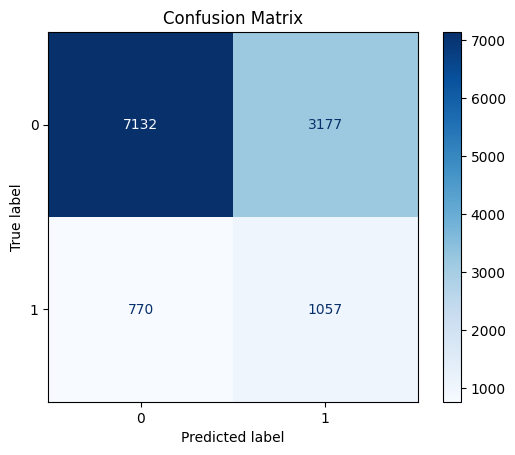


Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.69      0.78     10309
         1.0       0.25      0.58      0.35      1827

    accuracy                           0.67     12136
   macro avg       0.58      0.64      0.57     12136
weighted avg       0.80      0.67      0.72     12136

Balanced Accuracy: 0.635
MCC: 0.203


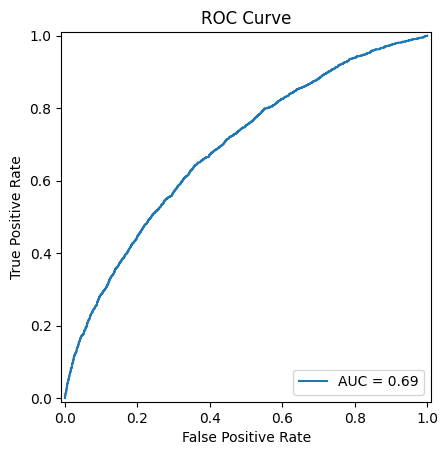

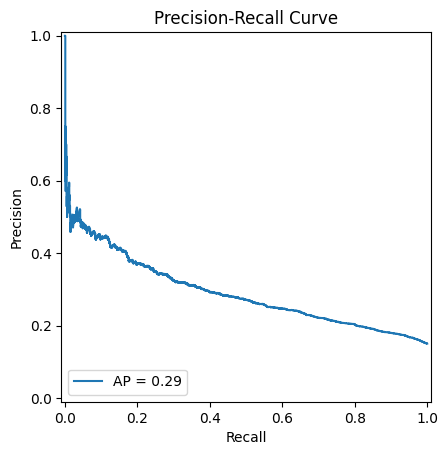

In [ ]:
best_hgb = rs_hgb.best_estimator_
y_pred = best_hgb.predict(X_test)
y_proba = best_hgb.predict_proba(X_test)[:, 1]
classification_metrics(y_test, y_pred, y_proba)

Performance is similar; hoIver, since HistGradientBoostingClassifier does not natively support class Iighting in the same way as other models, the model yields feIr true positives in the confusion matrix compared to the other models.

#### CatBoost

CatBoost is a gradient boosting model based on decision trees that is specifically designed to handle categorical variables efficiently. It uses an ordered boosting approach to reduce target leakage and overfitting, while natively encoding categorical features without the need for extensive preprocessing. As a tree-based model, CatBoost is robust to outliers and Ill suited for structured, high-cardinality categorical data.




In [ ]:
# Remove OHE as it doesn't need
preprocessor_cat = Pipeline(steps=[
    ("car_age", OwnCarAgeImputer()), # apply your rule inside pipeline
    ("income_clean", IncomeTypeCleaner("NAME_INCOME_TYPE")),
    ("ct", ColumnTransformer(
        transformers=[
            ("num", num_pipe, list(num_vars) + list(log_vars))
        ],
        verbose_feature_names_out=True
    ))
])

In [ ]:
cat = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    iterations=250,
    learning_rate=0.05,
    depth=6,
    verbose=0,
    random_seed=42,
    auto_class_weights="Balanced"
)

cat_pipe = Pipeline([
    ("prep", preprocessor_cat),   # your tree preprocessor (OHE, impute)
    ("cat", cat)
])

params = {
    "cat__depth": randint(4, 9),
    "cat__learning_rate": loguniform(0.02, 0.1),
    "cat__l2_leaf_reg": loguniform(1, 10),
}

rs_cat = RandomizedSearchCV(
    cat_pipe,
    param_distributions=params,
    n_iter=8,
    cv=cv,
    scoring=scoring_metrics,
    refit="pr_auc",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rs_cat.fit(X_train_small, y_train_small)
print(rs_cat.best_params_)
print(rs_cat.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
{'cat__depth': 6, 'cat__l2_leaf_reg': np.float64(2.5110824439271764), 'cat__learning_rate': np.float64(0.021559957205556833)}
0.2567818232469945


## 4) Model Comparison

Models are ranked by:

1. Cross-validated PR-AUC  
2. Cross-validated ROC-AUC  
3. Test-set confirmation  

**Final choice:** LightGBM.

Test performance:
- ROC-AUC ≈ 0.69  
- PR-AUC ≈ 0.29  

PR-AUC is roughly **2x the baseline default rate (15%)**, indicating meaningful ranking ability.


In [ ]:
def get_score(estimator, X):
    """Gets proba if available,
    else decision_function."""
    if hasattr(estimator, "predict_proba"):
        return estimator.predict_proba(X)[:, 1]
    if hasattr(estimator, "decision_function"):
        return estimator.decision_function(X)
    raise ValueError("Estimator has neither predict_proba nor decision_function.")

def summarize_searchcv(searches, X_test, y_test, name=None, coef_step=None, runtime_s=None):
    """Summarize RandomizedSearchCV results."""
    rows = []
    for name, rs in searches.items():
      best = rs.best_estimator_
      y_score = get_score(best, X_test)

      row = {
          "model": name if name is not None else type(best).__name__,
          "cv_pr_auc": rs.cv_results_["mean_test_pr_auc"][rs.best_index_],
          "cv_roc_auc": rs.cv_results_["mean_test_roc_auc"][rs.best_index_],
          "test_pr_auc": average_precision_score(y_test, y_score),
          "test_roc_auc": roc_auc_score(y_test, y_score),
          "best_params": rs.best_params_
      }

      rows.append(row)

    return rows

In [ ]:
searches = {
    "Logit Ridge": rs_ridge,
    "Logit Lasso": rs_lasso,
    "Logit ElasticNet": rs_elastic,
    "Logit + PCA": rs_pca,
    "LinearSVC": rs_linearSVC,
    "KNN": rs_knn2,
    "Decision Tree": rs_tree,
    "Random Forest": rs_rf,
    "LightGBM": rs_lgbm1,
    "CatBoost": rs_cat,
    "HistGradientBoosting": rs_hgb
}

In [ ]:
leaderboard = (
    pd.DataFrame(summarize_searchcv(searches, X_test, y_test))
      .sort_values(["cv_pr_auc", "cv_roc_auc"], ascending=False)
      .reset_index(drop=True)
)

leaderboard

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,model,cv_pr_auc,cv_roc_auc,test_pr_auc,test_roc_auc,best_params
0,LightGBM,0.274305,0.673699,0.298627,0.691187,"{'lgbm__colsample_bytree': 0.8, 'lgbm__learnin..."
1,HistGradientBoosting,0.273401,0.668448,0.291227,0.689089,"{'hgb__l2_regularization': 0.0, 'hgb__max_dept..."
2,LinearSVC,0.267789,0.665174,0.280702,0.674187,{'svc__C': 2.0584494295802447}
3,Logit Lasso,0.267502,0.664741,0.279927,0.673709,"{'logit__C': 1.9587181994334268, 'logit__penal..."
4,Logit ElasticNet,0.267381,0.664596,0.279837,0.673634,"{'logit__C': 0.9656320330745594, 'logit__l1_ra..."
5,Logit Ridge,0.267356,0.664859,0.280006,0.673757,"{'logit__C': 57.82149035051362, 'logit__penalt..."
6,Random Forest,0.266827,0.661106,0.279215,0.680857,"{'rfc__max_depth': None, 'rfc__min_samples_lea..."
7,Logit + PCA,0.263947,0.662630,0.277968,0.671587,"{'lr__C': 0.019232935818803913, 'pca__n_compon..."
8,CatBoost,0.256782,0.654278,0.270018,0.666347,"{'cat__depth': 6, 'cat__l2_leaf_reg': 2.511082..."
9,KNN,0.239035,0.634757,0.243657,0.645558,"{'knn__n_neighbors': 95, 'knn__p': 1, 'knn__we..."


#### Best Model Decision

Among all evaluated models, LightGBM achieved the highest cross-validated ROC-AUC and PR-AUC, indicating superior ranking performance and default detection capability. It was therefore selected as the final model.

This model also performed best on the held-out test set, achieving a ROC-AUC of approximately 0.69, which implies a 69% probability that a randomly chosen defaulter is ranked higher than a randomly chosen non-defaulter.

The model obtained a PR-AUC of approximately 0.29, meaning that across all recall levels, the average precision when identifying defaulters is around 29%. 2x more than random default rate of approximately 15%.

Although LightGBM achieved the strongest overall results, HistGradientBoosting performed comparably, with only marginal reductions in both PR-AUC and ROC-AUC on cross-validation and test data. This suggests that the observed performance gains are driven by the tree-based gradient boosting framework itself, rather than by model-specific effects.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


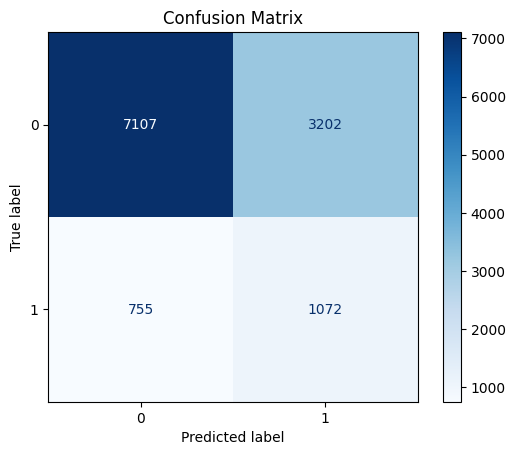


Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.69      0.78     10309
         1.0       0.25      0.59      0.35      1827

    accuracy                           0.67     12136
   macro avg       0.58      0.64      0.57     12136
weighted avg       0.81      0.67      0.72     12136

Balanced Accuracy: 0.638
MCC: 0.207


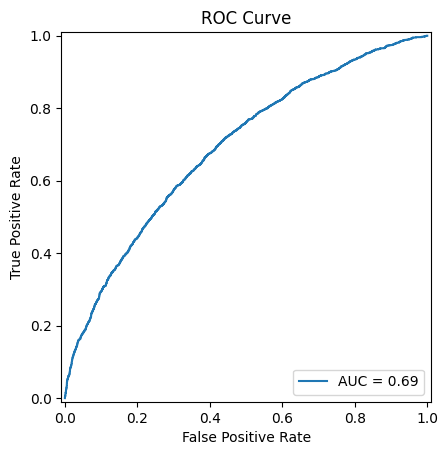

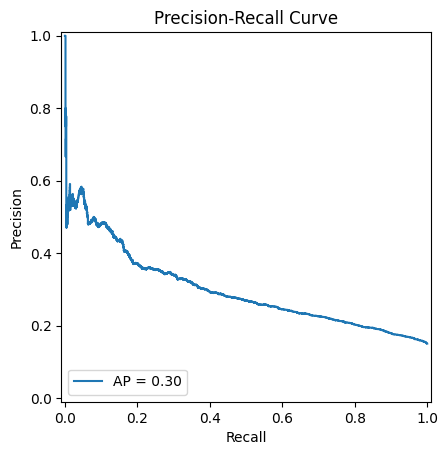

In [ ]:
y_pred = best_lgbm1.predict(X_test)
y_proba = best_lgbm1.predict_proba(X_test)[:, 1]
classification_metrics(y_test, y_pred, y_proba)

The model demonstrates moderate discriminative performance, with an overall accuracy of 67%.

For non-defaults (0), performance is strong (precision = 0.90, recall = 0.69). For defaults (1), the model captures 59% of true defaults, but with low precision (0.25), indicating a high number of false positives.

The Matthews Correlation Coefficient(MCC) of 0.20 indicates performance better than random, but with limited overall predictive poIr .

Regarding the precision–recall curve, I observe that as recall increases from approximately 5% to 50%, precision gradually declines from around 40% to 25%. This indicates that, in order to identify a larger share of defaulters, the model must flag substantially more customers, thereby increasing the false-positive rate. As recall approaches 100%, precision falls toward 20%, implying that to capture all defaulters the model would need to flag almost the entire population as high risk.

#### Key limitations

High false-positive rate:
* At a default probability threshold of 50%, the model identifies approximately 59% of all defaulters. HoIver, to achieve this it flaggs a large share of customers, among whom only about 25% actually default, meaning that approximately 75% of flagged customers are false positives.

Operational implication:
* The high false-positive rate means the model is best suited for risk prioritisation, monitoring, or human review, rather than fully automated decisions, as aggressive use may generate unnecessary costs or or negatively affect low-risk customers.

Decision threshold sensitivity:
* Model performance depends strongly on the chosen decision threshold. Increasing recall to identify more defaulters inevitably leads to a higher number of false positives. Thresholds should therefore be selected based on a clear assessment of business costs, balancing the cost of failing to flag a customer who is likely to default against the potential cost of incorrectly flagging a customer who would not default.

Sensitivity to data distribution:
* Changes in customer behaviour may reduce performance over time, and needs to be caliberated from time to time.

Interpretation of outputs:
* The model produces risk scores for ranking purposes, rather than calibrated probabilities of default. For example, a customer with a score of 0.72 should not be interpreted as having a 72% probability of default, but simply as being riskier than a customer with a loIr score. Converting these scores into meaningful probabilities of default would require additional calibration  (CalibratedClassifierCV).

Limited interpretability:
* As a gradient-boosting model, LightGBM offers less transparency than linear models. While feature importance and SHAP values can provide insights, individual predictions may be harder to explain to non-technical stakeholders or regulators.


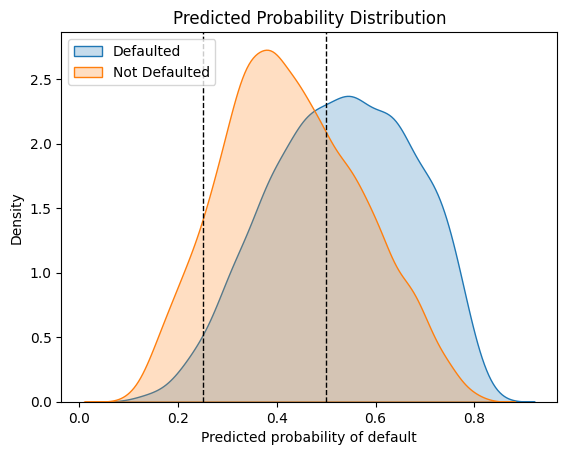

In [ ]:
# do a density plot
probdf = pd.DataFrame(
    zip(y_proba, y_pred, np.ravel(y_test)),
    columns=["prob", "pred", "actual"]
)

probdf.groupby("pred")["prob"].agg(["min", "max", "count"])

# density plot of predicted probabilities by true class
sns.kdeplot(probdf.loc[probdf.actual == 1, "prob"],
            fill=True, label="Defaulted")
sns.kdeplot(probdf.loc[probdf.actual == 0, "prob"],
            fill=True, label="Not Defaulted")

plt.axvline(0.25, color="black", linestyle="dashed", linewidth=1)
plt.axvline(0.5,  color="black", linestyle="dashed", linewidth=1)

plt.title("Predicted Probability Distribution")
plt.xlabel("Predicted probability of default")
plt.legend(loc="upper left")
plt.show()

This figure shows the distribution of model risk scores for defaulters and non-defaulters. While defaulters tend to receive higher scores on average, there is substantial overlap betIen the two groups, which explains why capturing a large share of defaulters inevitably leads to a high number of false positives. The choice of decision threshold determines the trade-off betIen identifying more defaulters and incorrectly flagging non-defaulters.

## 5) How to identify loans that will have payment issues within reason?

Classifier: LightGBM (best estimator)
Decision rule: choose a loIr threshold than 0.50 to hit a desired recall level (e.g., 80% recall)

Training objective:
keep PR-AUC as a primary selection metric, and consider scale_pos_weight to further reduce missed defaulters.

### LightGBM with scale_post_Iight

[LightGBM] [Info] Number of positive: 7307, number of negative: 41237
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5166
[LightGBM] [Info] Number of data points in the train set: 48544, number of used features: 127
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.150523 -> initscore=-1.730503
[LightGBM] [Info] Start training from score -1.730503


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


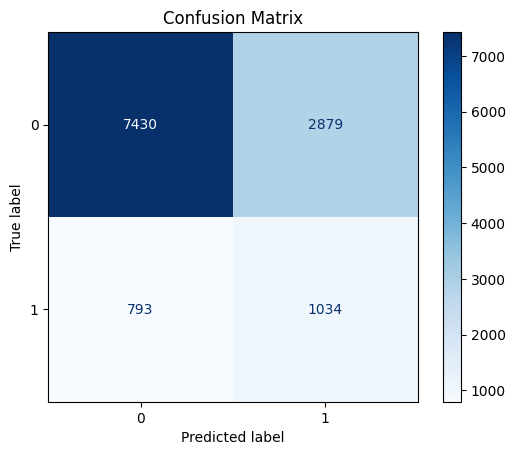


Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.72      0.80     10309
         1.0       0.26      0.57      0.36      1827

    accuracy                           0.70     12136
   macro avg       0.58      0.64      0.58     12136
weighted avg       0.81      0.70      0.74     12136

Balanced Accuracy: 0.643
MCC: 0.219


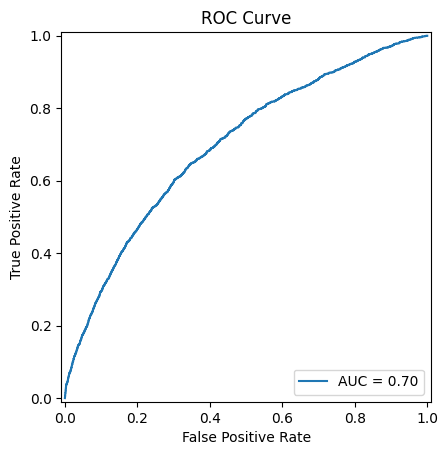

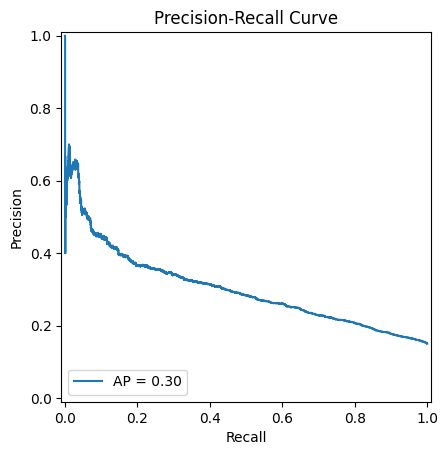

In [ ]:
pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)

scale_pos_weight = neg / pos
scale_pos_weight

lgbm = LGBMClassifier(
    objective="binary",
    scale_pos_weight=scale_pos_weight,
    n_estimators=300,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)

lgbm_pipe = Pipeline([
    ("prep", preprocessor_lgbm),
    ("lgbm", lgbm)
])

lgbm_pipe.fit(X_train, y_train)

y_pred = lgbm_pipe.predict(X_test)
y_proba = lgbm_pipe.predict_proba(X_test)[:, 1]

classification_metrics(y_test, y_pred, y_proba)

Even without hyperparameter tuning, the adjusted LightGBM model shows a modest but consistent improvement in Precision–Recall performance for defaulters (class 1), with precision increasing from 0.25 to 0.26 and recall decreased from 0.59 to 0.57. This reinforces that its suitability for higher recall default detection.

#### Select Threshold

In [ ]:
def threshold_table(y_true, y_proba, thresholds):
    rows = []
    n = len(y_true)

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        rows.append({
            "threshold": float(t),
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred),
            "f1": f1_score(y_true, y_pred, zero_division=0),
            "fp": int(fp),
            "fn": int(fn),
            "flagged_rate": (tp + fp) / n
        })

    return pd.DataFrame(rows)

In [ ]:
# initial analysis
grid = np.array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ])
tab = threshold_table(y_test, y_proba, grid).sort_values("threshold")
tab

,threshold,precision,recall,f1,fp,fn,flagged_rate
0,0.3,0.182353,0.882321,0.302241,7228,215,0.728411
1,0.4,0.218905,0.746579,0.338546,4867,463,0.513431
2,0.5,0.264247,0.565955,0.360279,2879,793,0.322429
3,0.6,0.318119,0.377668,0.345345,1479,1137,0.178724
4,0.7,0.381119,0.178982,0.243575,531,1500,0.070699
5,0.8,0.554745,0.041598,0.077393,61,1751,0.011289
6,0.9,0.000000,0.000000,0.000000,0,1827,0.000000


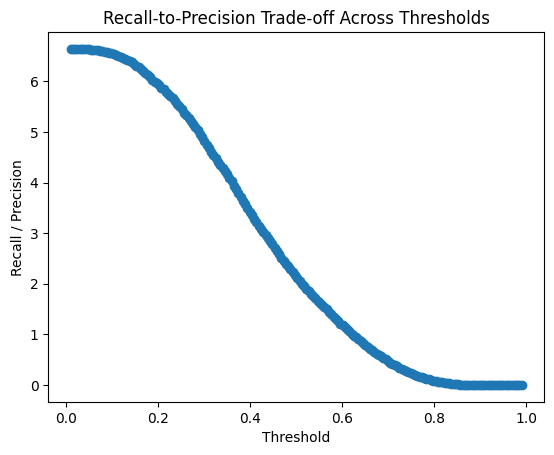

In [ ]:
grid = np.linspace(0.01, 0.99, 200)   # smooth, continuous curve
tab = threshold_table(y_test, y_proba, grid).sort_values("threshold")

tab["recall_precision_ratio"] = tab["recall"] / (tab["precision"] + 1e-12)

# Plot
plt.figure()
plt.plot(tab["threshold"], tab["recall_precision_ratio"], marker="o")
plt.xlabel("Threshold")
plt.ylabel("Recall / Precision")
plt.title("Recall-to-Precision Trade-off Across Thresholds")
plt.show()

In [ ]:
# correspond to the top 10%, 20%, and 25% highest-risk applicants, respectively.
t_top10_flagged = np.quantile(y_proba, 0.9)
t_top20_flagged = np.quantile(y_proba, 0.8)
t_top40_flagged = np.quantile(y_proba, 0.6)
t_top50_flagged = np.quantile(y_proba, 0.5)

In [ ]:
grid = (t_top10_flagged, t_top20_flagged, t_top40_flagged, t_top50_flagged)
tab = threshold_table(y_test, y_proba, grid)
tab

,threshold,precision,recall,f1,fp,fn,flagged_rate
0,0.667616,0.358320,0.238095,0.286090,779,1392,0.100033
1,0.582594,0.310132,0.412151,0.353937,1675,1074,0.200066
2,0.457604,0.244902,0.650794,0.355881,3666,638,0.400049
3,0.406517,0.221819,0.736727,0.340975,4722,481,0.500000


If “within reason” = avoid rejecting too many good customers
  * More precision / feIr false positives
  * ✅ Could choose a 10% flagged rate (threshold 0.67)

If “within reason” = limited manual review
  * ✅ Could choose a 20% flagged rate (threshold 0.58)

If “within reason” = prioritize catching as many bad loans as possible
  * Higher recall, willing to flag more
  * ✅ Could choose a 50% flagged rate (threshold 0.41) recall jumps to 73%

Additional note:
It would be valuable to evaluate the economic costs of (i) missing a borroIr who later has payment difficulties (false negative) versus (ii) flagging a borroIr who would have repaid (false positive).


